In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from typing import Tuple, List, Dict, Optional, Union
from torch import Tensor
import time

from pymatgen.analysis.diffraction.xrd import XRDCalculator

import json

from pymatgen.transformations.standard_transformations import RotationTransformation
from pymatgen.io.cif import CifParser

from scipy.optimize import curve_fit

import cmcrameri.cm as cm

from matplotlib import colors, animation
from IPython.display import HTML

import torch.nn as nn
import torch.optim as optim

from torchdiffeq import odeint, odeint_adjoint


dtype = torch.float32
device ='cuda:3' if torch.cuda.is_available() else 'cpu'



# Detector Class

In [2]:
## final steps, rescale by magnitude (bc fully elastic scattering)
##magnitde is 2pi/wavelength so add wavelength into detector class
## rescale kfp and K_i bc qvector is kfp-K_i
class Detector:
    def __init__(self,X,Y,d_xy,R,wavelength,dtype=dtype,device=device):
        self.X = X #number of pixels
        self.Y = Y #number of pixels
        self.i_grid, self.j_grid = torch.meshgrid(torch.linspace(0,X-1,X, dtype = dtype, device=device), torch.linspace(Y-1,0,Y, dtype = dtype, device=device), indexing="ij") #specific pixle

        self.R = R #detector distance
        self.d_xy = d_xy #detector pixel size

        self.wavelength = wavelength #wavelength

    def get_alpha_i(self):
        alpha_i = torch.atan(self.d_xy/self.R*(self.i_grid-self.X/2))
        return alpha_i


    def get_alpha_j(self):
        alpha_j = torch.atan(self.d_xy/self.R*(self.j_grid-self.Y/2))
        return alpha_j


    def get_M1(self, K_i, K_f):

        self.K_i = K_i #wave vector incedent
        self.K_f = K_f #outgoing wave vector to center

        self.k_f_expand = K_f.view(1,1,3).expand(self.X, self.Y, 3)
        self.k_i_expand = K_i.view(1,1,3).expand(self.X, self.Y, 3)

        a_i = self.get_alpha_i()

        k_1 = torch.linalg.cross(self.K_i, self.K_f) / torch.norm(torch.linalg.cross(self.K_i, self.K_f))
        k_1_expand = k_1.view(1,1,3).expand(self.X, self.Y, 3)

    #defining the operations
        cos_ai = torch.cos(a_i).unsqueeze(-1)
        cross_k1_kf = torch.linalg.cross(k_1_expand, self.k_f_expand, dim = 2)
        sin_ai = torch.sin(a_i).unsqueeze(-1)
        dot_k1_kf = torch.dot(k_1, self.K_f)

        M1 = self.k_f_expand * cos_ai + cross_k1_kf * sin_ai + k_1_expand * dot_k1_kf * (1 - cos_ai)
        return M1


    def get_kfp(self, K_i, K_f):
        v = self.get_M1(K_i, K_f)
        k_2 = (self.K_f - self.K_i) / torch.norm(self.K_f - self.K_i)
        k_2_expand = k_2.view(1,1,3).expand(self.X, self.Y, 3)
        a_j = self.get_alpha_j()
  
  #defining the operations
        dot_prod = torch.sum(k_2_expand * v, dim = 2, keepdim = True)
        cos_aj = torch.cos(a_j).unsqueeze(-1)
        cross_k2_v = torch.linalg.cross(k_2_expand, v, dim=2)
        sin_aj = torch.sin(a_j).unsqueeze(-1)

        kfp = v * cos_aj + cross_k2_v * sin_aj + k_2 * dot_prod * (1 - cos_aj)
        return kfp
  
    def get_q(self, K_i, K_f):
        kfp = self.get_kfp(K_i, K_f)
        kfp_mag = kfp * 2 * torch.pi / self.wavelength
        K_i_mag = K_i * 2 * torch.pi / self.wavelength
        q = kfp_mag - K_i_mag
        return q

    @staticmethod
    def round_in_base(x: float, digits: int = 2, base: int = 10) -> float:
        """
        Round a number to the specified significant digits in the given base.
        Parameters:
        -----------
        x: float
            Number to round
        digits: int
            Number of significant digits to maintain when rounding
        base: int
            Base in which to round to the nearest power
        Returns:
        --------
        float:
            Rounded number
        """
        if x == 0:
            return 0
        else:
            exponent = np.floor(math.log(abs(x), base))
            scale = base ** (exponent - digits + 1)
            rounded = round(x / scale) * scale
            return type(x)(rounded)
        
    '''
    def calculate_resolution(self, K_i, K_f) -> float:
        q = self.get_q(K_i, K_f)
        q_max = q.max()
        res = 2 * torch.pi/q_max
        return res
    '''

    
        


# Sample Class

In [3]:

class Crystal:
    """
    Class representing a crystal sample.
    """
    def __init__(
        self,
        cif_path: str,
        crystal_size: Tuple[int, int, int],
        dtype: torch.dtype = torch.float32,
        device: str = 'mps'
    ):
        """
        Initialize a Sample object.
        Parameters:
        -----------
        cif_path: str
            Path to cif file
        crystal_size: tuple
            Tuple of integers (n1, n2, n3) specifying crystal size in unit cells
        dtype: torch.dtype
            torch data type
        device: str
            torch device ('cuda' or 'cpu')
        """
        self.cif_path = cif_path
        self.crystal_size = crystal_size
        self.dtype = dtype
        self.device = device

        # Parse cif file
        self._parse_cif_file()
        
        # Parse atom types
        try:
            # If oxidation state is given, atom type is stored in element field of each specie
            self.atom_types = list(map(str, map(lambda x: x.element, self.structure.species)))
        except:
            # No oxidation state given
            self.atom_types = list(map(str, self.structure.species))

        # Get atomic form factors
        self.atomic_form_factors = self._load_atomic_form_factors()
        self._get_atomic_form_factor_coefficients()

        # Set global position (default is origin)
        self._position = torch.zeros(3, dtype=self.dtype, device=self.device)

    def _parse_cif_file(self):
        """
        Parse the CIF file and extract the structure object.
        """
        parser = CifParser(self.cif_path)
        self.structure = parser.parse_structures(primitive=False)[0]

    def _load_atomic_form_factors(self):
        """
        Load atomic form factor coefficients from JSON file.
        
        Parameters:
        -----------
        filename : str
            Path to the JSON file containing atomic form factor coefficients
            
        Returns:
        --------
        dict : Dictionary with element symbols as keys and coefficients as list of values
               Each coefficient list contains [a1, b1, a2, b2, a3, b3, a4, b4, c]
        """

        #with open(os.path.join(os.path.dirname(__file__), 'resources/atomic_form_factors.json'), 'r') as f:
            #data = json.load(f)
        file_path = os.path.join(os.getcwd(), "resources", "atomic_form_factors.json")
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        return data
    
    def _get_atomic_form_factor_coefficients(self):
        """
        Extract the coefficients of the atomic form factors for each atom in the structure.
        """
        
        self.coeff_a = torch.zeros((1, self.n_atoms, 4), dtype=self.dtype, device=self.device)
        self.coeff_b = torch.zeros((1, self.n_atoms, 4), dtype=self.dtype, device=self.device)
        self.coeff_c = torch.zeros((1, self.n_atoms), dtype=self.dtype, device=self.device)
        
        for i, atom_type in enumerate(self.atom_types):
            self.coeff_a[:,i] = torch.tensor(self.atomic_form_factors[atom_type][0:-1:2], dtype=self.dtype, device=self.device)
            self.coeff_b[:,i] = torch.tensor(self.atomic_form_factors[atom_type][1:-1:2], dtype=self.dtype, device=self.device)
            self.coeff_c[:,i] = torch.tensor(self.atomic_form_factors[atom_type][-1], dtype=self.dtype, device=self.device)

    def calculate_form_factors(self, q_magnitude: Tensor) -> Tensor:
        """
        Calculate the approximate atomic form factors as a sum of gaussians for each atom over the given q values.
        
        Parameters:
        -----------
        q_magnitude : torch.Tensor
            q vector magnitude as a tensor of shape [batch_size, 1]

        Returns:
        --------
        torch.Tensor:
            Approximated form factor amplitudes of shape [batch_size, n_atoms]
        """
        
        result = self.coeff_a.view(1,-1) * torch.exp(-self.coeff_b.view(1,-1) * (q_magnitude / (4 * torch.pi)) ** 2)
        
        return result.view(-1, self.n_atoms, 4).sum(dim=-1) + self.coeff_c

    @property
    def position(self) -> Tensor:
        return self._position

    @position.setter
    def position(self, value):
        self._position = value

    @position.deleter
    def position(self):
        del self._position
    
    @property
    def lattice_vectors(self) -> Tensor:
        return torch.tensor(self.structure.lattice.matrix * 1e-10, dtype=self.dtype, device=self.device)

    @property
    def atom_positions(self) -> Tensor:
        return torch.tensor(self.structure.cart_coords * 1e-10, dtype=self.dtype, device=self.device)

    @property
    def n_atoms(self) -> int:
        return len(self.atom_types)
        
    @property
    def n_cells(self) -> int:
        return self.crystal_size[0] * self.crystal_size[1] * self.crystal_size[2]

    @property
    def cell_volume(self) -> float:
        return torch.det(self.lattice_vectors).abs()

    @property
    def crystal_volume(self) -> float:
        return self.cell_volume * self.n_cells
            

    '''
    def calculate_crystal_properties(self, structure):
        self.lattice_vectors = torch.tensor(structure.lattice.matrix * 1e-10, dtype=self.dtype, device=self.device)
        self.atom_positions = torch.tensor(structure.cart_coords * 1e-10, dtype=self.dtype, device=self.device)
        try: self.atom_types = list(map(str, map(lambda x: x.element, structure.species)))
        except: self.atom_types = list(map(str, structure.species))
        self.n_atoms = len(self.atom_types)
        self.n_cells = self.crystal_size[0] * self.crystal_size[1] * self.crystal_size[2]
        self.cell_volume = torch.det(self.lattice_vectors).abs()
        self.sample_volume = self.cell_volume * self.n_cells
    '''

    def unit_cell_lattice(self, structure): #finish
        lattice_vectors = torch.tensor(structure.lattice.matrix * 1e-10, dtype=self.dtype, device=self.device)
        
        n1, n2, n3 = self.crystal_size

        
        i_indices = torch.arange(0, n1, 1, dtype=dtype, device=device)
        j_indices = torch.arange(0, n2, 1, dtype=dtype, device=device)
        k_indices = torch.arange(0, n3, 1, dtype=dtype, device=device)

            # Compute a grid of all indices

        i, j, k = torch.meshgrid(i_indices, j_indices, k_indices, indexing='xy')
 
            # Reshape to [n_unitcells, 3]

        unitcell_indices = torch.stack([i.flatten(), j.flatten(), k.flatten()], dim=1)

            # Calculate positions in real space --> this is R_n

        unitcell_positions = torch.matmul(unitcell_indices, lattice_vectors) ## full grid of R_nd


        atom_pos_unit_cell = self.crystal.atom_positions #initial atomic positions (Ask) I dont think this is right
        shape = atom_pos_unit_cell.shape

        total_pos = unitcell_pos[:,none,:] + atom_pos_unit_cell[none,:,:]

        return(total_pos.view(n1,n2,n3,shape))

    def align_miller_plane_to_axis(self, miller_indices, target_axis='x'):
        """
        Rotate a crystal structure so that the normal to a specified Miller plane
        is aligned with a target axis.
        
        Parameters:
        -----------
        miller_indices : tuple
            Miller indices (h, k, l) of the plane
        target_axis : str
            Target axis ('x', 'y', or 'z')
        """
        
        # Define target direction vectors
        target_directions = {
            'x': np.array([1, 0, 0]),
            'y': np.array([0, 1, 0]),
            'z': np.array([0, 0, 1])
        }
        
        if target_axis not in target_directions:
            raise ValueError("target_axis must be 'x', 'y', or 'z'")
        
        target_direction = target_directions[target_axis]

        # Save the original structure
        if not hasattr(self, 'original_structure'):
            self.original_structure = self.structure.copy()
        structure = self.original_structure.copy()
        
        # Get the reciprocal lattice
        reciprocal_lattice = structure.lattice.reciprocal_lattice
        
        # Calculate the normal vector to the Miller plane
        # Normal to (h,k,l) plane = h*a* + k*b* + l*c* (reciprocal lattice vectors)
        h, k, l = miller_indices
        miller_normal = (h * reciprocal_lattice.matrix[0] + 
                         k * reciprocal_lattice.matrix[1] + 
                         l * reciprocal_lattice.matrix[2])
        
        # Normalize the normal vector
        miller_normal = miller_normal / np.linalg.norm(miller_normal)
        
        # Calculate the rotation axis (cross product)
        rotation_axis = np.linalg.cross(miller_normal, target_direction)
        rotation_axis_norm = np.linalg.norm(rotation_axis)
        
        if rotation_axis_norm < 1e-10:  # Already aligned or anti-aligned
            if np.dot(miller_normal, target_direction) > 0:
                # Already aligned, no rotation needed
                return
            else:
                # Anti-aligned, need 180° rotation
                # Choose a perpendicular axis for 180° rotation
                rotation_axis = np.roll(target_direction, shift = 1)
                rotation_angle = np.pi
        else:
            rotation_axis = rotation_axis / rotation_axis_norm
            
            # Calculate rotation angle
            rotation_angle = np.arccos(np.clip(np.dot(miller_normal, target_direction), -1.0, 1.0))
        
        # Apply rotation transformation
        transformation = RotationTransformation(rotation_axis, rotation_angle, angle_in_radians=True)
        rotated_structure = transformation.apply_transformation(structure)

        self.structure = rotated_structure


    def misalign_about_axis(self, rotation_angle=0., rotation_axis='y'):
        """
        Rotate a crystal structure to misalign it.
        
        Parameters:
        -----------
        rotation angle : float
            Angle in degrees by which to misalign the structure
        rotation_axis : str
            Rotation axis ('x', 'y', or 'z')
        """

        # Define rotation axis vectors
        rotation_axis_directions = {
            'x': np.array([1, 0, 0]),
            'y': np.array([0, 1, 0]),
            'z': np.array([0, 0, 1])
        }

        rotation_axis = rotation_axis_directions[rotation_axis]
        
        # Apply rotation transformation
        transformation = RotationTransformation(rotation_axis, rotation_angle, angle_in_radians=False)
        self.structure = transformation.apply_transformation(self.structure)
    '''

    def _load_atomic_form_factors(self):
        """
        Load atomic form factor coefficients from JSON file.
        
        Parameters:
        -----------
        filename : str
            Path to the JSON file containing atomic form factor coefficients
            
        Returns:
        --------
        dict : Dictionary with element symbols as keys and coefficients as list of values
               Each coefficient list contains [a1, b1, a2, b2, a3, b3, a4, b4, c]
        """
        with open('atomic_form_factors.json', 'r') as f:
            data = json.load(f)
        
        return data
        
    def get_atomic_form_factors(self) -> List[Tensor]:
        self.atomic_form_factors = {
            'O': [3.0485, 13.2771, 2.2868, 5.7011, 1.5463, 0.3239, 0.867, 32.9089, 0.2508],
            'Zn': [14.0743, 3.2655, 7.0318, 0.2333, 5.1652, 10.3163, 2.41, 58.7097, 1.3041],
            'Ba': [20.3361, 3.216, 19.297, 0.2756, 10.888, 20.2073, 2.6959, 167.202, 2.7731],
            'Ti': [9.7595, 7.8508, 7.3558, 0.5, 1.6991, 35.6338, 1.9021, 116.105, 1.2807],
            'Na': [4.7626, 3.285, 3.1736, 8.8422, 1.2674, 0.3136, 1.1128, 129.424, 0.676],
            'B':[2.0545, 23.2185, 1.3326, 1.021, 1.0979, 60.3498, 0.7068, 0.1403, -0.1932],
            'H':[0.489918, 20.6593, 0.262003, 7.74039, 0.196767, 49.5519, 0.049879, 2.20159, 0.001305]
        }
 
        self.coeff_a = torch.zeros((1, self.n_atoms, 4), dtype=self.dtype, device=self.device)
        self.coeff_b = torch.zeros((1, self.n_atoms, 4), dtype=self.dtype, device=self.device)
        self.coeff_c = torch.zeros((1, self.n_atoms), dtype=self.dtype, device=self.device)
        for i, atom_type in enumerate(self.atom_types):
            self.coeff_a[:,i] = torch.tensor(self.atomic_form_factors[atom_type][0:-1:2], dtype=self.dtype, device=self.device)
            self.coeff_b[:,i] = torch.tensor(self.atomic_form_factors[atom_type][1:-1:2], dtype=self.dtype, device=self.device)
            self.coeff_c[:,i] = torch.tensor(self.atomic_form_factors[atom_type][-1], dtype=self.dtype, device=self.device)
    def calculate_form_factors(self, q_magnitude: Tensor) -> Tensor:
        gaussians = self.coeff_a.view(1,-1) * torch.exp(-self.coeff_b.view(1,-1) * (q_magnitude / (4 * torch.pi)) ** 2)
        return gaussians.view(-1, self.n_atoms, 4).sum(dim=-1) + self.coeff_c
    '''

    def get_XRD(self, structure, xrd_wavelength='CuKa'):
        xrd_calc = XRDCalculator(wavelength=xrd_wavelength)
        pattern = xrd_calc.show_plot(structure)
        val = xrd_calc.get_pattern(structure)
        return pattern, val

    def get_dislocations(self,scale):
        #scale should be size in m
        u = torch.randn(self.crystal_size + self.atom_positions.shape, device = device) * scale ##this creates a dislocation field
        return u
    
    def apply_alternating_dislocation(self, scale: float):
        """
        Apply alternating dislocations along the (1,2) component of the displacement field.

        Parameters:
        -----------
        scale : float
            Magnitude of the displacement to apply
        """
        u = torch.zeros_like(self.get_dislocations(scale))
        nx, ny, nz, _, _ = self.get_dislocations(scale).shape

        # Create meshgrid of indices
        i, j, k = torch.meshgrid(
            torch.arange(nx, device=u.device),
            torch.arange(ny, device=u.device),
            torch.arange(nz, device=u.device),
            indexing="ij"
        )

    
        
        # Apply displacement
        u[:, :, :, 1, 0] = torch.where(i>j, scale, -scale)
        u[:, :, :, 1, 0] = torch.where(i==j, 0, u[:,:,:,1,0])
        
        '''
        parity = (i + j + k) % 2 == 1  # shape [nx, ny, nz]

        # Expand to [nx, ny, nz, n_atoms]
        parity = parity[:, :, :, None].expand(-1, -1, -1, u.shape[3])

        # Apply displacements in the x-direction (index 0)
        u[:, :, :, :, 0] = torch.where(parity, scale, -scale)
        '''
        return u

    def animate_displacement(self, w, t, scale):
        return scale * torch.cos(w*t) + self.get_dislocations(scale)
        #start with a cos function that evolves with time
        #loop simulation over the time

    def scale_displacement(self, w, t, scale):
        return torch.cos(w*t) * self.apply_alternating_dislocation(scale)

    def grain_shape(self, structure, r_out):
        #return mask for shape
        lattice_vectors = torch.tensor(structure.lattice.matrix * 1e-10, dtype=self.dtype, device=self.device)
        
        n1, n2, n3 = self.crystal_size

        
        i_indices = torch.arange(0, n1, 1, dtype=dtype, device=device)
        j_indices = torch.arange(0, n2, 1, dtype=dtype, device=device)
        k_indices = torch.arange(0, n3, 1, dtype=dtype, device=device)

            # Compute a grid of all indices

        i, j, k = torch.meshgrid(i_indices, j_indices, k_indices, indexing='xy')

        center_i = n1 / 2
        center_j = n2 / 2
        center_k = n3 / 2

        dist_from_center = torch.sqrt((i - center_i)**2 + (j - center_j)**2 + (k - center_k)**2)

        mask = torch.ones((n1, n2, n3), dtype=dtype, device=device)

        mask[dist_from_center >= r_out] = 0
        
        

 
            # Reshape to [n_unitcells, 3]

        mask_flat = torch.stack([i.flatten(), j.flatten(), k.flatten()], dim=1)

        return mask_flat


In [4]:
class Polycrystal:
    """Collection of crystals (grains) that scatter coherently"""
    
    def __init__(
        self,
        cif_path: str,
        bounding_box: Tuple[float, float, float],
        crystal_sizes: Union[Tuple[int, int, int], List[Tuple[int, int, int]]],
        crystal_misorientations: List[Tuple[float, str]],
        miller_indices: Tuple[int, int, int],
        target_axis: str ='x',
        dtype: torch.dtype = torch.float32,
        device: str = 'cuda'
    ):
        """
        Initialize a Polycrystal object.
        
        Parameters:
        -----------
        cif_path: str
            Path to cif file
        bounding_box: tuple
            Tuple of floats delimiting the bounding box for all crystallites, in meters
        crystal_sizes: list
            Tuple of integers or list of tuples of integers (n1, n2, n3) specifying crystal sizes in unit cells.
            If tuple, all crystals will be considered the same size.
        miller_indices : tuple
            Miller indices (h, k, l) of the plane
        crystal_misorientations: list
            List of tuples of (angle, axis) specifying the rotation angle and axis by which to misalign crystal
        target_axis : str
            Target axis ('x', 'y', or 'z')
        dtype: torch.dtype
            torch data type
        device: str
            torch device ('cuda' or 'cpu')
        """

        self.bounding_box = torch.tensor(bounding_box, dtype=dtype, device=device)

        if isinstance(crystal_sizes, tuple):
            crystal_sizes = [crystal_sizes] * len(crystal_misorientations)
            
        self.grains = []
        for crystal_size, rotation in zip(crystal_sizes, crystal_misorientations):
            # Create crystal object
            self.grains.append(Crystal(cif_path, crystal_size, dtype, device))

            # Assign random global position within bounding box
            self.grains[-1].position = self.bounding_box * torch.rand(3, dtype=dtype, device=device)
            
            # Align Miller plane to axis
            self.grains[-1].align_miller_plane_to_axis(miller_indices, target_axis=target_axis)

            # Add slight misalignment
            self.grains[-1].misalign_about_axis(rotation_angle=rotation[0], rotation_axis=rotation[1])

    @property
    def n_grains(self) -> int:
        return len(self.grains)

# Dynamic Motion Class

In [5]:
class ODE(nn.Module):
    def __init__(self, method='dopri5', adjoint=False, requires_grad=True, dtype=torch.float32):
        super(ODE, self).__init__()

        self.method = method
        self.adjoint = adjoint if requires_grad else False
        self.odeint = odeint_adjoint if self.adjoint else odeint
        self.dtype = dtype


    def solve(self, t, y0, device='cpu', rtol=1e-7, atol=1e-9):
        if self.training:
            return self.odeint(self.to(device), y0.to(device), t.to(device), method=self.method,
                               rtol=rtol, atol=atol, options={'dtype':self.dtype})
        else:
            with torch.no_grad():
                return odeint(self.to(device), y0.to(device), t.to(device), method=self.method,
                              rtol=rtol, atol=atol, options={'dtype':self._dtype})

    def get_batch(self, t, y0, y, batch_time, batch_size):
        T, M = y.shape[:2]
        D = y.shape[-1]
        t_batch = t[:batch_time]
    
        c = [[i,j] for i in range(T - batch_time) for j in range(M)]
        b = [c[i] for i in np.random.choice(len(c), batch_size, replace=False)]
    
        for i in range(len(b)):
            if i==0:
                y0_batch = y[b[i][0], b[i][1]][None,:]
                y_batch = torch.stack([y[b[i][0]+j, b[i][1]] for j in range(batch_time)], dim=0)[:,None,:]
            else:
                y0_batch = torch.cat((y0_batch, y[b[i][0], b[i][1]][None,:]))
                y_batch = torch.cat((y_batch,
                    torch.stack([y[b[i][0]+j, b[i][1]] for j in range(batch_time)], dim=0)[:,None,:]), dim=1)
        return t_batch, y0_batch, y_batch


# swarm.solve will return a tensor of shape [n_steps, N, 4]

In [6]:
class NeuralODE(ODE):
    def __init__(self, args, method='dopri5', adjoint=False, dtype=torch.float32):   
        super(NeuralODE, self).__init__(method, adjoint=adjoint, requires_grad=True, dtype=dtype)
        
        default_args = {'N': 50,
                        'kernel_size': 11}
        
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)

        # Convolution operation with trainable kernel (self.conv.weight should have requires_grad=True; print to confirm!)
        self.conv = nn.Conv3d(1, 1, self.kernel_size, bias=False, padding='same', padding_mode='circular')
        nn.init.normal_(self.conv.weight, mean=0, std=0.01) # Initialize the kernel weights as random samples from a normal distribution
    
    def forward(self, t, y):
        y = y.view((-1, 1, self.N, self.N, self.N))
        cosy = torch.cos(y)
        siny = torch.sin(y)
        conv_cosy = self.conv(cosy)
        conv_siny = self.conv(siny)
        return (cosy * conv_siny - siny * conv_cosy).flatten(start_dim=-3)

In [7]:
# Might want to make more general than just swarmalators
# Calculate forward simulation in batches --> hopfully to reduce memory (loop to run first 10 and so on)
class Swarmalators(ODE):
    def __init__(self, N, args, crystal, method='dopri5', dtype=torch.float32):
        super(Swarmalators, self).__init__(method, adjoint=False, requires_grad=False, default_type=default_type)
        
        self.N = N
        
        default_args = {'A': 1,
                        'B': 1,
                        'J': 1,
                        'K': 1
                       } ## v and w will eventually factor in
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)

        self.crystal = crystal



    def forward(self, t, y): #theta

      # with the addition of theta, y is now (N,4) -- > (number of atoms, (x,y,z,theta))
        r_diff = y[None, :, :3,] - y[:, None, :3,]
        theta_diff = y[None, :, 3,] - y[:, None, 3,]
        r_norm = torch.linalg.norm(r_diff, dim= 2)
  
        mask = torch.eye(self.N, dtype=bool)  ## can prob change from self.N to read directly from y

        r_norm[mask] = 1.0
        cos_term = self.A + self.J * torch.cos(theta_diff)
        positional_term = r_diff / r_norm[..., None]
        norm_diff = positional_term * cos_term[...,None]
        norm_sqr_diff = self.B * r_diff / r_norm[...,None]**2
        total_pos_diff = norm_diff - norm_sqr_diff
        x_dot = 1/self.N * total_pos_diff.sum(dim=1)

        theta_dot = torch.sin(theta_diff) / r_norm
        theta_dot = self.K/self.N * theta_dot.sum(dim=1)

        total_diff = torch.cat((x_dot, theta_dot[:,None]), dim=1) 
        '''
        r_m = self.crystal.atom_positions
        n_atoms = r_m.shape[0]
        
        nx, ny, nz = self.crystal.crystal_size
        diff = total_diff.view(nx, ny, nz, n_atoms, 4)
        #return(diff[:,:,:,:3])
        '''


        return(total_diff)

In [8]:
# Note for self --> we want to only have Ti atoms moves, so take this into account with scattering later
class Kuramoto(ODE):
    def __init__(self, args, method='dopri5', dtype=torch.float32):   
        super(Kuramoto, self).__init__(method, adjoint=False, requires_grad=False, dtype=dtype)
        
        default_args = {'N': 50,
                        'K': 0.2,
                        's': 1.
                       }
        
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)

        # Get the true kernel
        kernel = self.K * self.laplacian_of_gaussian_kernel()[None, None]
        #kernel = self.K * self.boring_kernel()[None, None]

        # Convolution operation with kernel
        self.conv = nn.Conv3d(1, 1, kernel.shape[-1], bias=False, padding='same', padding_mode='circular')
        self.conv.weight = nn.Parameter(kernel, requires_grad=False)
    
    def laplacian_of_gaussian_kernel(self):
        # Extend kernel to three standard deviations
        d = int(np.ceil(3 * self.s))
        d_range = torch.arange(-d, d+1, dtype=self.dtype)

        # Create spatial grid over which to evaluate kernel
        x = torch.stack(torch.meshgrid(d_range, d_range, d_range, indexing='xy'))
        n = x.shape[0]

        # Evaluate laplacian of gaussian over grid
        kernel = torch.exp(-(x**2).sum(dim=0) / (2 * self.s**2))
        kernel *= -((x**2).sum(dim=0) / self.s**2 - n) / np.sqrt((2 * np.pi)**n) / self.s**(n + 2)
        kernel[d,d,d] = 0.
        
        return kernel #output is [kernel size,kernel size,kernel size]

    def boring_kernel(self):
        d = int(np.ceil(3 * self.s))
        d_range = torch.arange(-d, d+1, dtype=self.dtype)

        # Create spatial grid over which to evaluate kernel
        x = torch.stack(torch.meshgrid(d_range, d_range, d_range, indexing='xy'))
        kernel = torch.exp((-x**2).sum(dim=0))
        coords = torch.meshgrid(
        torch.arange(-d, d+1),
        torch.arange(-d, d+1),
        torch.arange(-d, d+1),
        indexing='ij'
        )
        x, y, z = coords
        dist = x.abs() + y.abs() + z.abs()   # Manhattan (L1) distance
    
        # Zero out the center octahedron of radius r
        r = 1   # or 2, etc., to control size
        kernel[dist <= r] = 0.
    

        return kernel
        
    def init_state(self, M=1, seed=12):
        torch.manual_seed(seed)
        return 2 * torch.pi * torch.rand((M, 1, self.N, self.N, self.N), dtype=self.dtype).flatten(start_dim=-3)
    
    def forward(self, t, y):
        y = y.view((-1, 1, self.N, self.N, self.N))
        cosy = torch.cos(y)
        siny = torch.sin(y)
        conv_cosy = self.conv(cosy)
        conv_siny = self.conv(siny)
        return (cosy * conv_siny - siny * conv_cosy).flatten(start_dim=-3)

In [9]:
class Dynamic_Motion:
    def __init__(self, crystal, device, index, dtype):
        self.crystal = crystal
        self.device = device
        self.index = index
        self.dtype = dtype
    def solve(self, model, args, d, tf, dt):
        r_m = self.crystal.atom_positions
        n_atoms = r_m.shape[0]
        nx, ny, nz = self.crystal.crystal_size
        dx, dy, dz = d
        
        vol = nx//dx * ny//dy * nz//dz
        N = vol * n_atoms

        ode = model(N, args, self.crystal, method='dopri5', default_type=self.dtype).to(self.device)


        y0= 2*torch.rand(vol * n_atoms,4, device = self.device)-1
        t = torch.arange(0, tf, dt)
        y = ode.solve(t, y0, device=self.device, rtol=1e-6, atol=1e-6)

        return((y.view(len(t), vol ,n_atoms,4))) #shape [#steps, sup_vol, n_Atoms, 4]

    def manual_input(self, disp, d, index):
        '''
        disp should be of shape [batch_size, channels, nx, ny, nz, 3] 
        '''
        batch_t, channel, nx, ny, nz, _ = disp.shape
        dx, dy, dz = d

        r_m = self.crystal.atom_positions
        n_atoms = r_m.shape[0]
        
        disp_sq = disp.squeeze(1)

        mask = torch.zeros(n_atoms, device=disp_sq.device)
        mask[self.index] = 1

        # Reshape mask so it can broadcast over disp_sq
        mask = mask.view(1, 1, 1, 1, n_atoms, 1)   # [1,1,1,1,n_atoms,1]

        u = disp_sq.unsqueeze(4) * mask

        u = u.view(
            batch_t,
            nx // dx, dx,
            ny // dy, dy,
            nz // dz, dz,
            n_atoms, 3
        )
        u_avg = u.mean(dim=(2, 4, 6))                                                       # [t,sx, sy, sz, n_atoms, 3]
        u_avg = u_avg.reshape(batch_t,-1, n_atoms, 3)                                               # [t,n_supercells, n_atoms, 3]

        return(u_avg)
        
## OK, so we want to replace   u_avg = [sx, sy, sz, n_atoms, 3] or u_avg = [n_supercells, n_atoms, 3] instead of u_full

# Scattering Class

$$A(q) = \frac{r_o\sqrt{\Phi_0}}{R}\sum_{R_n}\sum_{r_m} f_m(q)e^{-iq\cdot(R^m_n+u_m(R_n))}$$
$$\approx \frac{r_o\sqrt{\Phi_0}}{R}\prod_{i}d_i\sum_{R_{nd}}\sum_{r_m} f_m(q)e^{-iq\cdot(R^m_{dn}+\tilde{u}_m(R_{nd}))}$$

In [73]:
#start by generating a random list for spacing, and set form facter to 1 -> f
#u_tilde is ave displacement of atom m in the supercell at pos R_nd... we get these from the sample class above
# d_i are pos consant int values for each index i
#d_i goes 1, 2, 3
#d is size of super cell in each dim
#ni is diatance from or origin to lattice point
#pretend rm tilda for now
# Im just going to assume we know u_ave, R^m_dn and R_nd

class CoherentScattering:
    def __init__(self, crystal, K_i, K_f, detector, dtype=dtype, device=device):
        self.K_i = K_i
        self.K_f = K_f
        self.detector = detector
        self.q_vectors = self.detector.get_q(K_i,K_f)
        self.crystal = crystal
    
    #def animate_displacemet(self):
        #start with a cos function that evolves with time
        #loop simulation over the time  

    def bool_mask(self, d, shape_mask=None, r_out=None, start_coord=None, end_coord=None):
        """
        Creating different shaped grains
        """

        d1, d2, d3 = d
        n1, n2, n3 = self.crystal.crystal_size

        i_indices = torch.arange(0, n1, d1, dtype=dtype, device=device)
        j_indices = torch.arange(0, n2, d2, dtype=dtype, device=device)
        k_indices = torch.arange(0, n3, d3, dtype=dtype, device=device)

            # Compute a grid of all indices

        i, j, k = torch.meshgrid(i_indices, j_indices, k_indices, indexing='xy')
 
            # Reshape to [n_supercells, 3]

        supercell_indices = torch.stack([i.flatten(), j.flatten(), k.flatten()], dim=1)

            # Calculate positions in real space --> this is R_nd

        supercell_positions = torch.matmul(supercell_indices, self.crystal.lattice_vectors) ## full grid of R_nd


        
        if shape_mask == 'circle':
            center_i = (n1 - 1) / 2 / d1
            center_j = (n2 - 1) / 2 / d2
            center_k = (n3 - 1) / 2 / d3

            dist_from_center = torch.sqrt((i - center_i) ** 2 + 
                                          (j - center_j) ** 2 + 
                                          (k - center_k) ** 2)

            mask_bool = (dist_from_center < r_out).flatten()

        elif shape_mask == 'rectangle':

            x0, y0, z0 = start_coord #indicies
            x1, y1, z1 = end_coord #indicies
            '''
            mask_bool = (
                (supercell_indices[:, 0] >= x0) & (supercell_indices[:, 0] < x1) &
                (supercell_indices[:, 1] >= y0) & (supercell_indices[:, 1] < y1) &
                (supercell_indices[:, 2] >= z0) & (supercell_indices[:, 2] < z1)
            )
            '''
            mask_bool = (
                (supercell_positions[:, 0] >= x0) & (supercell_positions[:, 0] < x1) &
                (supercell_positions[:, 1] >= y0) & (supercell_positions[:, 1] < y1) &
                (supercell_positions[:, 2] >= z0) & (supercell_positions[:, 2] < z1)
            )
            


        elif shape_mask == 'combo':
            # rectangle
            mask_rect = torch.zeros((n1, n2, n3), device=device)
            z_start, y_start, x_start = start_coord
            z_end, y_end, x_end = end_coord

            z0, z1 = max(0, z_start), min(n1, z_end)
            y0, y1 = max(0, y_start), min(n2, y_end)
            x0, x1 = max(0, x_start), min(n3, x_end)

            mask_rect[z0:z1, y0:y1, x0:x1] += 1


            # circle
            center_i = (n1 - 1) / 2
            center_j = (n2 - 1) / 2
            center_k = (n3 - 1) / 2


            # Compute distance from center for each grid point
            dist_from_center = torch.sqrt((i - center_i) ** 2 + (j - center_j) ** 2 + (k - center_k) ** 2)

            

            mask1 = (dist_from_center < r_out).to(dtype=dtype)  # [n1, n2, n3]

            mask_tot = mask1 + mask_rect
            mask_no_zero = mask_tot[mask_tot != 0]
            mask_bool = mask_no_zero.bool().flatten().unsqueeze(-1)
            '''
            center_i = (n1 - 1) / 2 / d1
            center_j = (n2 - 1) / 2 / d2
            center_k = (n3 - 1) / 2 / d3
            dist_from_center = torch.sqrt((i - center_i) ** 2 +
                                          (j - center_j) ** 2 +
                                          (k - center_k) ** 2)
            mask_circle = (dist_from_center < r_out)

            mask_bool = (mask_rect | mask_circle).flatten().unsqueeze(-1)
            '''

        else:
            mask_bool = torch.ones((n1 * n2 * n3,), dtype=torch.bool, device=device).unsqueeze(-1)

        return mask_bool


    def calculate_structure_factor(self) -> Tensor:


            # Store original shape of q_vectors for later reshaping

        batch_size_original = self.q_vectors.shape[:-1]

            # Reshape q_vectors to [batch_size, 3] for matrix multiplication

        q_vectors_flat = self.q_vectors.reshape(-1, 3)

        batch_size = q_vectors_flat.shape[0]

            # Calculate q·r for each atom in the unit cell and each q-vector

            # q_vectors_flat shape: [batch_size, 3]

            # atom_positions shape: [n_atoms, 3]

            # result shape: [batch_size, n_atoms]
        
        q_dot_r = torch.matmul(q_vectors_flat, self.crystal.atom_positions.T)

            # Calculate |q| for form factor (convert to Å for typical form factor formulas)

        q_magnitude = torch.norm(q_vectors_flat, dim=1, keepdim=True) * 1e-10  # [batch_size, 1]

 
            # Vectorized calculation of form factors for all atoms and all q values

        form_factors = self.crystal.calculate_form_factors(q_magnitude)

            # Calculate e^(-iq·r) for each atom and each q-vector

            # Result shape: [batch_size, n_atoms]

        phase_factors = torch.exp(-1j * q_dot_r)

            # Multiply by form factors and sum over atoms

            # result shape: [batch_size]

        structure_factor = torch.sum(form_factors * phase_factors, dim=1)

            # Reshape back to original q_vectors shape

        structure_factor = structure_factor.view(batch_size_original)

        return(structure_factor)


    def R_sum(self,d, shape_mask = None, r_out = None, start_coord = None, end_coord = None):  # d and n should b tuples with 3 values

        
        d1, d2, d3 = d
        n1, n2, n3 = self.crystal.crystal_size

            # Generate supercell indices

        i_indices = torch.arange(0, n1, d1, dtype=dtype, device=device)
        j_indices = torch.arange(0, n2, d2, dtype=dtype, device=device)
        k_indices = torch.arange(0, n3, d3, dtype=dtype, device=device)

            # Compute a grid of all indices

        i, j, k = torch.meshgrid(i_indices, j_indices, k_indices, indexing='xy')
 
            # Reshape to [n_supercells, 3]

        supercell_indices = torch.stack([i.flatten(), j.flatten(), k.flatten()], dim=1)

            # Calculate positions in real space --> this is R_nd

        supercell_positions = torch.matmul(supercell_indices, self.crystal.lattice_vectors) ## full grid of R_nd

        if shape_mask == None:
            supercell_positions_masked = supercell_positions ## full grid of R_nd

        elif shape_mask is False:
            supercell_positions_masked = supercell_positions ## full grid of R_nd

        else:
            mask_bool = self.bool_mask(d, shape_mask, r_out, start_coord, end_coord)
            # Apply mask to positions
            supercell_positions_masked = supercell_positions[mask_bool]
        
        '''
        if shape_mask is None:
            supercell_positions = torch.matmul(supercell_indices, self.crystal.lattice_vectors)
            
        else:
            center_i = (n1 - 1) / 2
            center_j = (n2 - 1) / 2
            center_k = (n3 - 1) / 2

            # Downsampled center
            center_i /= d1
            center_j /= d2
            center_k /= d3


            # Compute distance from center for each grid point
            dist_from_center = torch.sqrt((i - center_i) ** 2 + (j - center_j) ** 2 + (k - center_k) ** 2)

            

            mask = (dist_from_center < r_out).to(dtype=dtype)  # [n1, n2, n3]
            mask = mask.flatten().unsqueeze(-1)  # [n1, n2, n3, 1]

        
            supercell_positions = supercell_positions * mask  # [n1, n2, n3, 3]
        '''
            


            # Resizing q
    
        batch_size_original = self.q_vectors.shape[:-1]
        q_vectors_flat = self.q_vectors.reshape(-1, 3)
        batch_size = q_vectors_flat.shape[0]

            # Calculating dot_prod
    
        dot_prod_R = torch.matmul(q_vectors_flat, supercell_positions_masked.T)

            # Finding the exponential component

        phase_R = torch.exp(-1j * dot_prod_R)

        R_comp = torch.sum(phase_R, dim=1)

        final_R = R_comp.view(batch_size_original)*d1*d2*d3

        return(final_R) 
        
    def global_phase_factor(self):
        # Add global position phase shift

        # Calculate q·R_g for each q-vector

        # grain_position shape: [3]

        # q_vectors_flat shape: [n_pixels, 3]

        # Result shape: [n_pixels]

        batch_size_original = self.q_vectors.shape[:-1]

        q_vectors_flat = self.q_vectors.reshape(-1, 3)

        q_dot_global_position = torch.matmul(q_vectors_flat, self.crystal.position)

        # Calculate e^(-iq·R_g) for each q-vector

        global_phase_factor = torch.exp(-1j * q_dot_global_position)

        return(global_phase_factor.view(batch_size_original))
 

    
    def get_intensity(self,d,shape_mask = None, r_out = None, start_coord = None, end_coord = None):

        q = self.q_vectors

        A = self.R_sum(d, shape_mask, r_out, start_coord, end_coord)*self.calculate_structure_factor()*self.global_phase_factor()
        return A.abs()**2

    def get_amplitude(self,d,shape_mask = None, r_out = None, start_coord = None, end_coord = None):

        q = self.q_vectors

        A = self.R_sum(d, shape_mask, r_out, start_coord, end_coord)*self.calculate_structure_factor()*self.global_phase_factor()
        return A

    '''

    ## This max_intensity DOES NOT calculate R from scratch

    def max_intensity(self, R, d_xy, beta, rotated_structure):

        self.sample.calculate_sample_properties(rotated_structure) 

        N = self.sample.n_cells

        return(self.calculate_structure_factor()**2 * N**2 / R**2)

    ## The max_intensity function below calculates R from scratch, this should be used if we do not have a defined R

   '''     

    def max_intensity(self, rotated_structure):

        R = self.detector.R
        
        self.crystal.calculate_crystal_properties(rotated_structure) 

        N = self.crystal.n_cells

        S = self.calculate_structure_factor()
        
        return(S.abs()**2 * N**2 / R**2)


    
        
        

# Scattering with Dislocation

In [150]:
# THIS IS SCATTERING WITH ADDED DISLOCATIONS
# UPDATE GLOBAL PHASE

class CoherentScattering_dislocate:
    def __init__(self, crystal, K_i, K_f, detector, dtype=dtype, device=device): #model = model
        self.K_i = K_i
        self.K_f = K_f
        self.detector = detector
        self.q_vectors = self.detector.get_q(K_i,K_f)
        self.crystal = crystal

    def bool_mask(self, d, shape_mask=None, r_out=None, start_coord=None, end_coord=None):
        """
        Creating different shaped grains
        """

        d1, d2, d3 = d
        n1, n2, n3 = self.crystal.crystal_size

        i_indices = torch.arange(0, n1, d1, dtype=dtype, device=device)
        j_indices = torch.arange(0, n2, d2, dtype=dtype, device=device)
        k_indices = torch.arange(0, n3, d3, dtype=dtype, device=device)

            # Compute a grid of all indices

        i, j, k = torch.meshgrid(i_indices, j_indices, k_indices, indexing='xy')
 
            # Reshape to [n_supercells, 3]

        supercell_indices = torch.stack([i.flatten(), j.flatten(), k.flatten()], dim=1)

            # Calculate positions in real space --> this is R_nd

        supercell_positions = torch.matmul(supercell_indices, self.crystal.lattice_vectors) ## full grid of R_nd


        
        if shape_mask == 'circle':
            center_i = (n1 - 1) / 2 / d1
            center_j = (n2 - 1) / 2 / d2
            center_k = (n3 - 1) / 2 / d3

            dist_from_center = torch.sqrt((i - center_i) ** 2 + 
                                          (j - center_j) ** 2 + 
                                          (k - center_k) ** 2)

            mask_bool = (dist_from_center < r_out).flatten()

        elif shape_mask == 'rectangle':

            x0, y0, z0 = start_coord #indicies
            x1, y1, z1 = end_coord #indicies
            '''
            mask_bool = (
                (supercell_indices[:, 0] >= x0) & (supercell_indices[:, 0] < x1) &
                (supercell_indices[:, 1] >= y0) & (supercell_indices[:, 1] < y1) &
                (supercell_indices[:, 2] >= z0) & (supercell_indices[:, 2] < z1)
            )
            '''
            mask_bool = (
                (supercell_positions[:, 0] >= x0) & (supercell_positions[:, 0] < x1) &
                (supercell_positions[:, 1] >= y0) & (supercell_positions[:, 1] < y1) &
                (supercell_positions[:, 2] >= z0) & (supercell_positions[:, 2] < z1)
            )
            


        elif shape_mask == 'combo':
            # rectangle
            mask_rect = torch.zeros((n1, n2, n3), device=device)
            z_start, y_start, x_start = start_coord
            z_end, y_end, x_end = end_coord

            z0, z1 = max(0, z_start), min(n1, z_end)
            y0, y1 = max(0, y_start), min(n2, y_end)
            x0, x1 = max(0, x_start), min(n3, x_end)

            mask_rect[z0:z1, y0:y1, x0:x1] += 1


            # circle
            center_i = (n1 - 1) / 2
            center_j = (n2 - 1) / 2
            center_k = (n3 - 1) / 2


            # Compute distance from center for each grid point
            dist_from_center = torch.sqrt((i - center_i) ** 2 + (j - center_j) ** 2 + (k - center_k) ** 2)

            

            mask1 = (dist_from_center < r_out).to(dtype=dtype)  # [n1, n2, n3]

            mask_tot = mask1 + mask_rect
            mask_no_zero = mask_tot[mask_tot != 0]
            mask_bool = mask_no_zero.bool().flatten().unsqueeze(-1)
            '''
            center_i = (n1 - 1) / 2 / d1
            center_j = (n2 - 1) / 2 / d2
            center_k = (n3 - 1) / 2 / d3
            dist_from_center = torch.sqrt((i - center_i) ** 2 +
                                          (j - center_j) ** 2 +
                                          (k - center_k) ** 2)
            mask_circle = (dist_from_center < r_out)

            mask_bool = (mask_rect | mask_circle).flatten().unsqueeze(-1)
            '''

        else:
            mask_bool = torch.ones((n1 * n2 * n3,), dtype=torch.bool, device=device).unsqueeze(-1)

        return mask_bool


        
        
    def calculate_sum(self, d, scale, model, index=None, 
                      tf=None, dt=None, args=None, shape_mask = None, 
                      r_out = None, start_coord = None, end_coord = None) -> Tensor:

        '''
        --------------------------------------
        d: supercell size
        scale: how large are your dislocations
        model: what your dynamics are 
               (Currently just Swarmalators)
        tf: final time that dyanmics run until
        dt: size of time step
        args: A B J K vals for Swarmalators
        if you want to use manual input, model = disp
        --------------------------------------

        '''

        #shape_mask = self.crystal.grain_shape(structure, r_out)
        q_vectors_flat = self.q_vectors.reshape(-1, 3)  # [batch_size, 3]
        
        batch_size_original = self.q_vectors.shape[:-1]

        # Supercell positions R_nd
        d1, d2, d3 = d
        n1, n2, n3 = self.crystal.crystal_size

        with torch.no_grad():
            i_indices = torch.arange(0, n1, d1, dtype=dtype, device=device)
            j_indices = torch.arange(0, n2, d2, dtype=dtype, device=device)
            k_indices = torch.arange(0, n3, d3, dtype=dtype, device=device)

            # Compute a grid of all indices

            i, j, k = torch.meshgrid(i_indices, j_indices, k_indices, indexing='xy')
 
            # Reshape to [n_supercells, 3]

            supercell_indices = torch.stack([i.flatten(), j.flatten(), k.flatten()], dim=1)

            # Calculate positions in real space --> this is R_nd

        #This is our R_nd comp
        
            supercell_positions = torch.matmul(supercell_indices, self.crystal.lattice_vectors) ## full grid of R_nd
        '''   
        if shape_mask == None:
            supercell_positions_masked = supercell_positions ## full grid of R_nd

        elif shape_mask is False:
            supercell_positions_masked = supercell_positions ## full grid of R_nd

        else:
            mask_bool = self.bool_mask(d, shape_mask, r_out, start_coord, end_coord).squeeze(-1)
                # Apply mask to positions
            supercell_positions_masked = supercell_positions[mask_bool]
        '''
        mask_bool = torch.ones(supercell_positions.shape[0], dtype=torch.bool, device=device).cpu()
        
        if shape_mask is None or shape_mask is False:
            supercell_positions_masked = supercell_positions
            mask_bool = torch.ones(supercell_positions.shape[0], dtype=torch.bool, device=device).cpu()
        else:
            mask_bool = self.bool_mask(d, shape_mask, r_out, start_coord, end_coord).squeeze(-1).cpu()
            supercell_positions_masked = supercell_positions[mask_bool]
            
                
        #This is our r_m comp
       

        r_m = self.crystal.atom_positions
        
        
        n_atoms = r_m.shape[0]

        if model == 'Swarmalators':
       
            u_comp =  Dynamic_Motion(self.crystal, device, index, dtype)
            vals = u_comp.solve(Swarmalators, args, d, tf, dt) 
            u_avg = vals[..., :3] * scale                                             # [time_steps ,n_supercells, n_atoms, 3]
            u_avg_masked = u_avg[:, mask_bool, :, :]
        else:
            motion = Dynamic_Motion(self.crystal, device, index, dtype)
            u_avg = motion.manual_input(disp=model, d = d, index = index) * scale     # model = disp  [time_steps ,n_supercells, n_atoms, 3]
            u_avg_masked = u_avg[:, mask_bool, :, :]

        # Form factors (broadcasted)
        q_magnitude = torch.norm(q_vectors_flat, dim=1, keepdim=True) * 1e-10         # [batch_size, 1]
        
        
        f_q = self.crystal.calculate_form_factors(q_magnitude)                        # [batch_size, n_atoms]
        f_q = f_q[None, :, None, :]                                                   # [1, batch_size, 1, n_atoms]
        
        
        r = r_m[None, None, :, :]                                                     # [1, 1, n_atoms, 3]
        u = u_avg_masked ##Updated for mask                                           # [steps, n_supercells_masked, n_atoms, 3]
        t_step = u.shape[0]

        #Summing the m dependant components
        
        m_dep_pos = r.to(device) + u.to(device)                                      # [steps, n_supercells_masked, n_atoms, 3]
    

        q_dot_m = torch.einsum('bi,tsai->tbsa',q_vectors_flat, m_dep_pos)            # [time_steps, batch_size, n_supercells_masked, n_atoms]
       
        m_dep_phase = torch.exp(-1j*q_dot_m)
        m_structure_factor = f_q * m_dep_phase

        m_sum = torch.sum(m_structure_factor, dim = -1)                              # [batch_size, n_supercells_masked]

        with torch.no_grad():
            q_dot_R = torch.matmul(q_vectors_flat, supercell_positions_masked.T)     #[batch_size, n_supercells_masked]
        
            R_phase = torch.exp(-1j * q_dot_R)

        ## Summing over Rnd

        tot_sum = torch.sum(m_sum * R_phase[None,...], dim = 2) * d1 * d2 * d3 
        
        return tot_sum.view(t_step, *batch_size_original)

    def global_phase_factor(self):
        
        # Add global position phase shift

        # Calculate q·R_g for each q-vector

        # grain_position shape: [3]

        # q_vectors_flat shape: [n_pixels, 3]

        # Result shape: [n_pixels]

        batch_size_original = self.q_vectors.shape[:-1]

        q_vectors_flat = self.q_vectors.reshape(-1, 3)

        q_dot_global_position = torch.matmul(q_vectors_flat, self.crystal.position)

        # Calculate e^(-iq·R_g) for each q-vector

        global_phase_factor = torch.exp(-1j * q_dot_global_position)

        return(global_phase_factor.view(batch_size_original))

    
        
    def get_intensity(self, d, scale, model, lambda_max, index=None, tf=None, dt=None, args=None, poisson = False, 
                      shape_mask = None, r_out = None, start_coord = None, end_coord = None):

    
        A = self.calculate_sum(d, scale, model, index, tf, dt, args, shape_mask, r_out,
                              start_coord, end_coord) * self.global_phase_factor()

        I = A.abs()**2


        if poisson == True:

            I_scale = I * lambda_max/I.max()

            I_scale = torch.poisson(I_scale)
            
        else:

            I_scale = I * lambda_max/I.max()

        return I_scale

        '''
        
        if poisson == True:

            scale = lambda_max/I.max()

            I_scale = I * scale

            I_scale_poisson = torch.poisson(I_scale)

            I_poisson = torch.poisson(I_scale)/scale

            return I_poisson
            
        else:
            return I
        '''

        
    

    def get_amplitude(self, d, scale, model, lambda_max, index=None, tf=None, dt=None, args=None, 
                      shape_mask = None, r_out = None, start_coord = None, end_coord = None):

    
        A = self.calculate_sum(d, scale, model, index, tf, dt, args, shape_mask, r_out,
                              start_coord, end_coord) * self.global_phase_factor()

        A_scale = A * np.sqrt(lambda_max)/A.abs().max()

        return A_scale

         

    def two_time_correlation(self, I, r_in, r_out):  # normalize to run from zero to one -- check paper for exact norm
         #ave I over annulus in detector and do I ave over that
        
        # Get time-dependent intensities: shape [time_steps, X, Y]
        #A = self.get_intensity(d, scale, model, tf, dt, args)   
        I_fluctuation = I-I.mean()

        # Reshape to [T, N] where N = number of pixels
        
        T = I.shape[0]   # Number of Time steps
        MX, MY = I.shape[1], I.shape[2]
        center_x, center_y = MX // 2, MY // 2
        yy, xx = torch.meshgrid(torch.arange(MX), torch.arange(MY), indexing="ij")
        dist_from_center = torch.sqrt((xx - center_x)**2 + (yy - center_y)**2)
        mask = torch.logical_and(dist_from_center >= r_in, dist_from_center <= r_out).int()
        
        ## Extract I values from mask --> like actually extract them
        masked_I = I_fluctuation * mask.to(I.device)

        I_no_zero = masked_I[masked_I != 0]
        
        I_flat = I_no_zero.view(T, -1)   # flatten detector pixels

        
        # Compute mean intensity per frame [T, 1] -> should be averaged over q, but is this inherently in q?
        I_mean = I_flat.sum(dim=1, keepdim=True)/mask.sum()

        # Normalize intensities to remove baseline
        I_norm = I_flat / I_mean ## Do I keep U mean?

        # Compute g2 by matrix multiplication (normalized correlation)
        g2 = (I_norm @ I_norm.T) / I_norm.shape[1]
        '''
        valid_pixels = mask.sum()
        I_flat = I_flat[:, :valid_pixels]

        # Cartesian product (matrix multiply) over pixels
        g2 = (I_flat @ I_flat.T) / valid_pixels
        '''
        return g2

   
    def autocorrelation(self, I, r_in, r_out): # normalize to run from one to two
        # I is intensity fluctuation, so maybe subtract from I.mean
        #changing it so you have to run seprately

        #A = self.get_intensity(d, scale, model, tf, dt, args)

        I_fluctuation = I-I.mean()

        T = I.shape[0]

        tau_list = torch.arange(0,T, dtype=I.dtype, device=I.device)



        # create annulus shaped mask here, then ave over this
        MX, MY = I.shape[1], I.shape[2]
        center_x, center_y = MX // 2, MY // 2
        yy, xx = torch.meshgrid(torch.arange(MX), torch.arange(MY), indexing="ij")
        dist_from_center = torch.sqrt((xx - center_x)**2 + (yy - center_y)**2)
        mask = torch.logical_and(dist_from_center >= r_in, dist_from_center <= r_out).int()

        ## Extract I values from mask
        masked_I = I_fluctuation * mask.to(I.device)
        
        
        I_sum = masked_I.view(I.shape[0], -1).sum(dim=1)     # [Time steps]
        N_pixels = mask.sum()                                # number of pixels in annulus

        # Average intensity in annulus for each time step
        I_avg = I_sum / N_pixels  

        I_mean = I_avg.mean()
        
        
        product = I_avg[None,:] * I_avg[:, None]

        g2_vals = torch.tensor([product.diagonal(offset=int(tau)).sum() / (T + 1 - tau) for tau in tau_list], device=I.device) / (I_mean**2)

        
        return tau_list, g2_vals
    '''
    def grain_scatter(self, crystal, list_of_sup):
    '''


        


        

# Testing Scatter

In [135]:
a = 3.25e-10
c = 5.2e-10
 
crystal = Crystal(
    'BaTiO3.cif',
    crystal_size = (50, 50, 50),
    dtype = dtype,
    device = device
)
 
#structure = crystal.parse_cif_file()
rotated_structure = crystal.align_miller_plane_to_axis((1,1,0), target_axis='x')
#crystal.calculate_crystal_properties(rotated_structure)
#crystal.get_atomic_form_factors()
#lengths = crystal.lattice_vectors.norm(dim=1)
#print('Sample size:', ' nm x '.join('{:.1f}'.format(crystal.crystal_size[i] * lengths[i] * 1e9) for i in range(len(lengths))), 'nm')

In [136]:
## R value is coming out suspicoiusly small right now, I think my N might be off
def get_R(crystal, beta, rotated_structure, wavelength, d_xy):
        

    N = crystal.n_cells
        
    lattice_vectors = crystal.lattice_vectors
        
    a1_m, a2_m, a3_m = lattice_vectors.cpu()  # each is a 3-element NumPy array
        # this is in hkl
    

    a_norm = np.linalg.norm(a1_m)


    k = 2*torch.pi / wavelength # can also get this using the k_i/f vals

    R = d_xy * beta * k * (N**(1/3)) * a_norm / torch.pi

    return R

In [137]:
wavelength = 1.5406e-10 #m
theta_B = torch.deg2rad(torch.torch.tensor(31.57126512/2, dtype=dtype, device = device)) 
k_i = torch.tensor([torch.sin(-theta_B), 0.0, torch.cos(-theta_B)], dtype=dtype, device=device)
k_f = torch.tensor([torch.sin(theta_B), 0., torch.cos(theta_B)], dtype=dtype, device=device)

R = get_R(crystal = crystal, beta = 5, rotated_structure = rotated_structure, wavelength = wavelength, d_xy = 50e-6)
print(R)

0.06503443


In [151]:

scattering = CoherentScattering_dislocate(crystal = crystal,
                                K_i = k_i,
                                K_f = k_f,
                                detector = Detector(
                                    X = 128,
                                    Y = 128,
                                    d_xy = 50e-6,
                                    R = R,
                                    #R = 0.3946,
                                    wavelength = wavelength,
                                    dtype=dtype,
                                    device=device
                                ),
                                dtype=dtype,
                                device=device)


In [145]:
scattering_perf = CoherentScattering(crystal = crystal,
                                K_i = k_i,
                                K_f = k_f,
                                detector = Detector(
                                    X = 128,
                                    Y = 128,
                                    d_xy = 50e-6,
                                    R = R,
                                    #R = 0.3946,
                                    wavelength = wavelength,
                                    dtype=dtype,
                                    device=device
                                ),
                                dtype=dtype,
                                device=device)
inten_perf = scattering_perf.get_intensity(d=(10,10,10), shape_mask = 'circle', r_out = 20)
inten_perf = inten_perf[None,:,:]

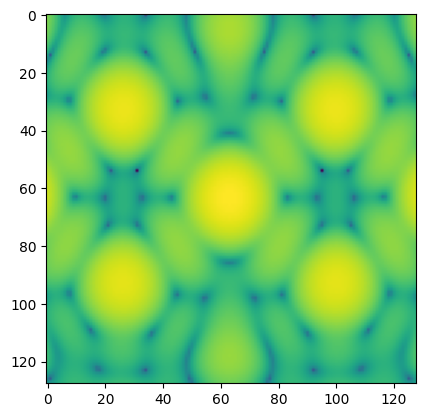

In [127]:
plt.imshow(inten_perf[0,:,:].cpu(), norm=colors.LogNorm())

# Kuramoto

In [117]:
method = 'dopri5'
adjoint = False

args = {'N': 50,
        'K': 10.,
        's': 1.5
       }
M = 1 # Number of initial conditions

kuramoto = Kuramoto(args, method, dtype).to(device)
y0 = kuramoto.init_state(M)

t0 = 10
tf = 50 + t0//2
T = 2*tf + 1

t = torch.linspace(0, tf, T)
T -= t0
print('Number of time steps:', T)

ts = time.time()
y = kuramoto.solve(t, y0, device=device, rtol=1e-6, atol=1e-6)
y = y[t0:] # Exclude initial transients from time series
print('Execution time (s):', time.time() - ts)

Number of time steps: 101
Execution time (s): 34.21121954917908


Text(0.5, 1.0, 'True Kernel')

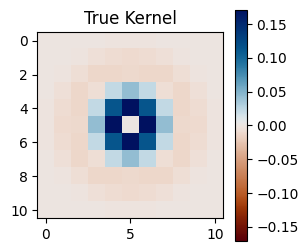

In [110]:
kernel = kuramoto.conv.weight.squeeze().cpu()
vmax = kernel.abs().max()
norm = plt.Normalize(vmin=-vmax, vmax=vmax)
fig, ax = plt.subplots(figsize=(3,3))
sm = ax.imshow(kernel[..., kernel.shape[-1] // 2], cmap=cm.vik_r, norm=norm)
plt.colorbar(sm, ax=ax);
plt.title("True Kernel")



In [111]:
print(kernel.sum(), kernel.mean())

tensor(-0.2123) tensor(-0.0002)


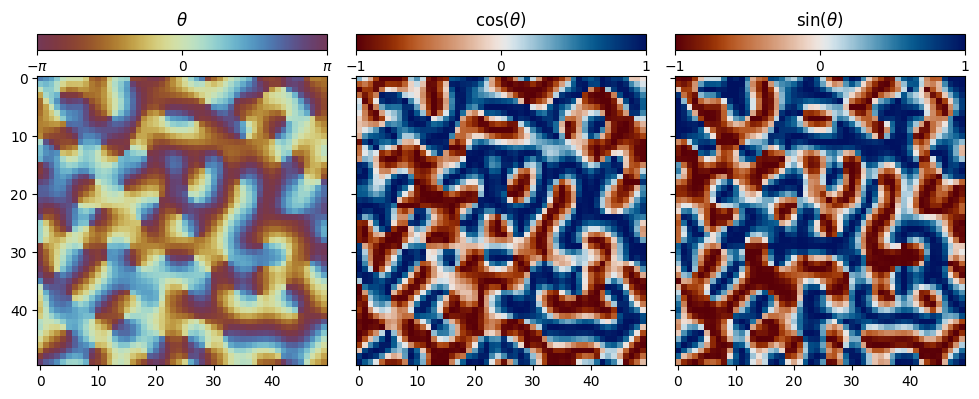

In [112]:
y_reshaped = y.reshape(-1, M, kuramoto.N, kuramoto.N, kuramoto.N).cpu()

i = -1
j = 0
fig, ax = plt.subplots(2,3, figsize=(10,4), gridspec_kw={'height_ratios': [0.05,1]}, sharey='row')
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)

sm = ax[1,0].imshow(y_reshaped[i,j,...,0] % (2 * torch.pi) - torch.pi, cmap=cm.romaO, vmin=-np.pi, vmax=np.pi)
cbar = plt.colorbar(sm, cax=ax[0,0], orientation='horizontal', ticks=[-np.pi, 0, np.pi])
ax[0,0].set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
ax[0,0].set_title(r'$\theta$')

sm = ax[1,1].imshow(torch.cos(y_reshaped[i,j,...,0]), cmap=cm.vik_r, vmin=-1, vmax=1)
cbar = plt.colorbar(sm, cax=ax[0,1], orientation='horizontal', ticks=[-1, 0, 1])
ax[0,1].set_title(r'$\cos(\theta)$')

sm = ax[1,2].imshow(torch.sin(y_reshaped[i,j,...,0]), cmap=cm.vik_r, vmin=-1, vmax=1)
cbar = plt.colorbar(sm, cax=ax[0,2], orientation='horizontal', ticks=[-1, 0, 1])
ax[0,2].set_title(r'$\sin(\theta)$');

## Training

In [163]:
args = {'N': kuramoto.N,
        'kernel_size': 11
       }

node = NeuralODE(args, method='dopri5', adjoint=False, dtype=dtype).to(device)
optimizer = optim.Adam(node.parameters(), lr=1e-4)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=5e-3, gamma = 0.9)
model_path = 'node_gauss_ka11_kg11_diff_L1_er+7_circle.pth' #change for each ground truth and hyper peram of neural ode
print(node)

NeuralODE(
  (conv): Conv3d(1, 1, kernel_size=(11, 11, 11), stride=(1, 1, 1), padding=same, bias=False, padding_mode=circular)
)


In [164]:
# Set up training parameters
max_iters = 500
batch_time = 10
batch_size = 1

try: saved = torch.load(model_path, weights_only=True)
except:
    chkpt = 10
    loss = []
    weights = []

else:
    chkpt = saved['chkpt']
    loss = saved['loss']
    weights = saved['weights']
    
    node.load_state_dict(saved['state'])
    node.to(device)
    optimizer.load_state_dict(saved['optimizer'])
    scheduler.load_state_dict(saved['scheduler'])

In [165]:
d = (10,10,10)
scale = .05 * crystal.lattice_vectors.norm()
args = {'A': 1,
        'B': 1,
        'J': 1,
        #'K':-0.75
        'K':-0.1
       }

tf = 50
dt=0.5

lambda_max = 1e+7




In [173]:
# Basic training loop when comparing predicted and true states in real 
# L1 loss
end = time.time()


for k in range(1, max_iters + 1):
    # Set out neural network to training mode
    node.train()

    # Zero the gradients of the optimizer
    optimizer.zero_grad()

    # Get a random batch of time windows and initial conditions from our full dataset
    t_batch, y0_batch, y_batch = node.get_batch(t, y0, y, batch_time, batch_size)

    # Integrate neural ODE from sampled initial conditions
    y_pred = node.solve(t_batch, y0_batch, device=device, rtol=1e-6, atol=1e-6)


    # Implement X-ray diffraction
    y_batch_shaped = y_batch.view(-1, batch_size, kuramoto.N, kuramoto.N, kuramoto.N)
    y_pred_shaped = y_pred.view(-1, batch_size, kuramoto.N, kuramoto.N, kuramoto.N)

    displacement_batch = torch.stack([torch.cos(y_batch_shaped), torch.sin(y_batch_shaped), torch.zeros_like(y_batch_shaped)], dim=-1)
    displacement_pred = torch.stack([torch.cos(y_pred_shaped), torch.sin(y_pred_shaped), torch.zeros_like(y_pred_shaped)], dim=-1)
    
    I0_pred = scattering.get_intensity(d=d, scale=5e-10, model = displacement_pred, lambda_max = lambda_max, index = 1, shape_mask = 'circle', r_out = 20)
    I0_pred_diff = scattering.get_intensity(d=d, scale=5e-10, model = displacement_pred, lambda_max = lambda_max, index = 1) - inten_perf


    I0_batch = scattering.get_intensity(d=d, scale=5e-10, model = displacement_batch, lambda_max = lambda_max, index = 1, poisson = True,  shape_mask = 'circle', r_out = 20)
    I0_batch_diff = scattering.get_intensity(d=d, scale=5e-10, model = displacement_batch, lambda_max = lambda_max, index = 1, poisson = True) - inten_perf

    # Compute MSE between predicted and ground truth trajectories 
    _loss = nn.L1Loss()(I0_pred_diff, I0_batch_diff)

    # Backpropagate gradients
    _loss.backward()

    # Update weights
    optimizer.step()
    scheduler.step()

    # Checkpoint loss periodically
    if k % chkpt == 0:
        with torch.no_grad():
            loss.append(_loss.item())
            print('Iteration: {:04d} | Total Loss: {:.2e} | Time: {:.6f}'.format(k, _loss.item(), time.time() - end))
            weights.append(node.conv.weight.detach().cpu())
        
        end = time.time()


Iteration: 0010 | Total Loss: 1.07e+03 | Time: 40.809128
Iteration: 0020 | Total Loss: 1.03e+03 | Time: 40.798011
Iteration: 0030 | Total Loss: 9.88e+02 | Time: 40.804842
Iteration: 0040 | Total Loss: 9.91e+02 | Time: 40.796391
Iteration: 0050 | Total Loss: 9.68e+02 | Time: 40.831146
Iteration: 0060 | Total Loss: 9.91e+02 | Time: 40.805396
Iteration: 0070 | Total Loss: 9.53e+02 | Time: 40.803100
Iteration: 0080 | Total Loss: 9.00e+02 | Time: 40.808485
Iteration: 0090 | Total Loss: 9.36e+02 | Time: 40.811837
Iteration: 0100 | Total Loss: 9.03e+02 | Time: 40.800826
Iteration: 0110 | Total Loss: 9.72e+02 | Time: 40.798150
Iteration: 0120 | Total Loss: 8.44e+02 | Time: 40.802048
Iteration: 0130 | Total Loss: 8.05e+02 | Time: 40.794461
Iteration: 0140 | Total Loss: 1.03e+03 | Time: 40.805692
Iteration: 0150 | Total Loss: 7.91e+02 | Time: 40.791023
Iteration: 0160 | Total Loss: 7.61e+02 | Time: 40.791719
Iteration: 0170 | Total Loss: 7.86e+02 | Time: 40.806499
Iteration: 0180 | Total Loss: 8

Text(0, 0.5, 'Loss')

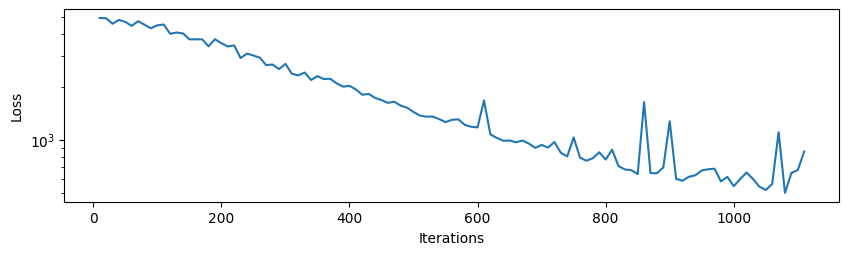

In [175]:
# Plot the loss as a function of training iterations
fig, ax = plt.subplots(figsize=(10,2.5))
ax.plot([chkpt * k for k in range(1, len(loss) + 1)], loss)
ax.set_yscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')

In [176]:
torch.save({
    'scheduler': scheduler.state_dict(),
    'state': node.state_dict(), #make list to append to
    'weights': weights,
    'optimizer': optimizer.state_dict(),
    'chkpt': chkpt,
    'loss': loss
}, model_path)

In [177]:
#print(weights[0])

'\nplt.imshow(inten_perf[0,...].cpu(),norm=colors.LogNorm())\nplt.xlabel("X Pixels")\nplt.ylabel("Y Pixels")\nplt.title("BaTiO3 (1,1,0) Diffraction Pattern")\ncbar = plt.colorbar()\ncbar.set_label("Intensity")\nplt.show()\n\n'

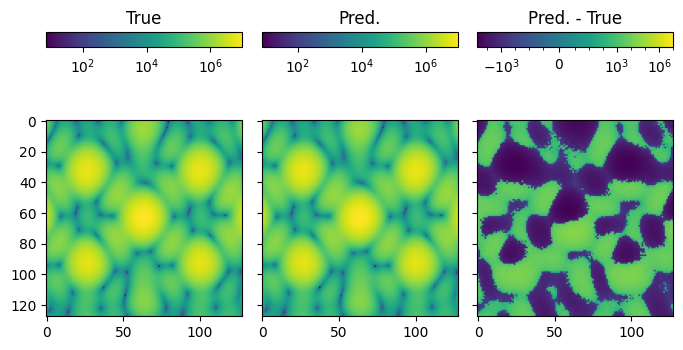

In [178]:
y_batch = y_batch.view(-1, batch_size, kuramoto.N, kuramoto.N, kuramoto.N).detach().cpu()
y_pred = y_pred.view(-1, batch_size, kuramoto.N, kuramoto.N, kuramoto.N).detach().cpu()
displacement_batch = torch.stack([torch.cos(y_batch), torch.sin(y_batch), torch.zeros_like(y_batch)], dim=-1)
displacement_pred = torch.stack([torch.cos(y_pred), torch.sin(y_pred), torch.zeros_like(y_pred)], dim=-1)
I0_pred = scattering.get_intensity(d=d, scale=5e-10, model = displacement_pred, lambda_max = lambda_max, index = 1, shape_mask = 'circle', r_out = 20)


I0_batch = scattering.get_intensity(d=d, scale=5e-10, model = displacement_batch, lambda_max = lambda_max, poisson = True, index = 1, shape_mask = 'circle', r_out = 20)


i = -1
j = 0
fig, ax = plt.subplots(2,3, figsize=(7,4), gridspec_kw={'height_ratios': [0.05,1]}, sharey='row')
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)

I0_batch_diff = I0_batch - inten_perf
I0_pred_diff = I0_pred - inten_perf
sm = ax[1,0].imshow(I0_batch[1,...].cpu(),norm=colors.LogNorm())
cbar = plt.colorbar(sm, cax=ax[0,0], orientation='horizontal')
#ax[0,0].set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
ax[0,0].set_title('True')

sm = ax[1,1].imshow(I0_pred[1,...].cpu(), norm=colors.LogNorm())
cbar = plt.colorbar(sm, cax=ax[0,1], orientation='horizontal')
#ax[0,1].set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
ax[0,1].set_title('Pred.');

sm = ax[1,2].imshow((I0_pred[1,...].cpu())- I0_batch[1,...].cpu(), norm = matplotlib.colors.SymLogNorm(linthresh=1, vmax=lambda_max))
cbar = plt.colorbar(sm, cax=ax[0,2], orientation='horizontal')
cbar.set_ticks([-1e+3, 0, 1e+3, 1e+6])
#ax[0,1].set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
ax[0,2].set_title('Pred. - True');
'''
plt.imshow(inten_perf[0,...].cpu(),norm=colors.LogNorm())
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.title("BaTiO3 (1,1,0) Diffraction Pattern")
cbar = plt.colorbar()
cbar.set_label("Intensity")
plt.show()

'''

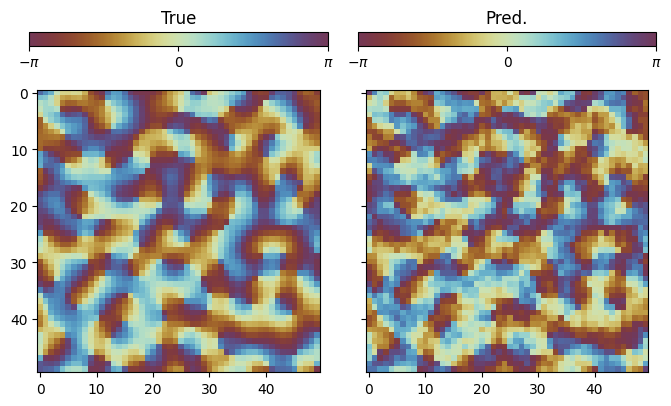

In [179]:

# Plot time step i and initial condition j
y_batch = y_batch.view(-1, batch_size, kuramoto.N, kuramoto.N, kuramoto.N).detach().cpu()
y_pred = y_pred.view(-1, batch_size, kuramoto.N, kuramoto.N, kuramoto.N).detach().cpu()

i = -1
j = 0
fig, ax = plt.subplots(2,2, figsize=(7,4), gridspec_kw={'height_ratios': [0.05,1]}, sharey='row')
fig.tight_layout()
fig.subplots_adjust(hspace=0.3, wspace=0.1)

sm = ax[1,0].imshow(y_batch[i,j,...,0] % (2 * torch.pi) - torch.pi, cmap=cm.romaO, vmin=-np.pi, vmax=np.pi)
cbar = plt.colorbar(sm, cax=ax[0,0], orientation='horizontal', ticks=[-np.pi, 0, np.pi])
ax[0,0].set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
ax[0,0].set_title('True')

sm = ax[1,1].imshow(y_pred[i,j,...,0] % (2 * torch.pi) - torch.pi, cmap=cm.romaO, vmin=-np.pi, vmax=np.pi)
cbar = plt.colorbar(sm, cax=ax[0,1], orientation='horizontal', ticks=[-np.pi, 0, np.pi])
ax[0,1].set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
ax[0,1].set_title('Pred.');

Text(0.5, 1.0, 'Predicted Kernel')

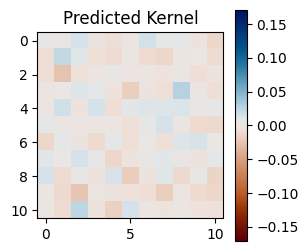

In [180]:
kernel_pred = node.conv.weight.squeeze().detach().cpu()
vmax_pred = kernel_pred.abs().max()
norm = plt.Normalize(vmin=-vmax, vmax=vmax)
fig, ax = plt.subplots(figsize=(3,3))
sm = ax.imshow(kernel_pred[..., kernel_pred.shape[-1] // 2], cmap=cm.vik_r, norm = norm)
plt.colorbar(sm, ax=ax)
plt.title("Predicted Kernel")


In [ ]:
displacement_true = torch.stack([torch.cos(y_batch), torch.sin(y_batch), torch.zeros_like(y_batch)], dim=-1)
displacement_batch = torch.stack([torch.cos(y_pred), torch.sin(y_pred), torch.zeros_like(y_pred)], dim=-1)

# Scatter

In [34]:
d = (10,10,10)
scale = .05 * crystal.lattice_vectors.norm()
args = {'A': 1,
        'B': 1,
        'J': 1,
        #'K':-0.75
        'K':-0.1
       }

tf = 50
dt=0.5

#self, d, scale, model, index=None, tf=None, dt=None, args=None
Amp = scattering.get_intensity(d=d, scale=5e-10
                               , model = displacement_true, index = 1)

I0 = Amp.abs()**2

Amp2 = scattering.get_intensity(d=d, scale=5e-10
                               , model = displacement_batch, index = 1)
I02 = Amp2.abs()**2

In [37]:
I0_batch.shape

torch.Size([10, 128, 128])

In [68]:
auto_corr = scattering.autocorrelation(I0_batch,0,20)

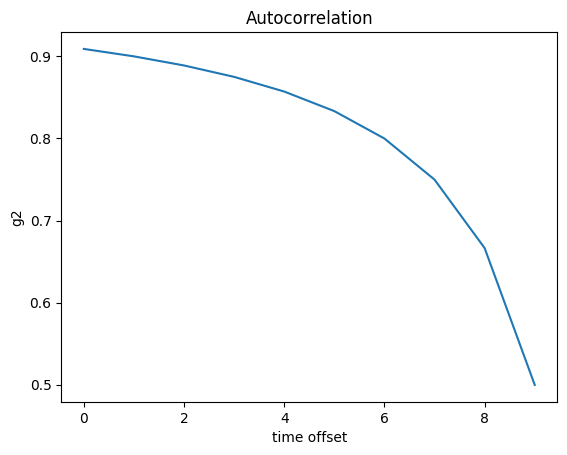

In [69]:
tau, g = auto_corr

plt.plot(tau.cpu(),g.cpu())
plt.xlabel('time offset')
plt.ylabel('g2')
plt.title('Autocorrelation')
plt.show()

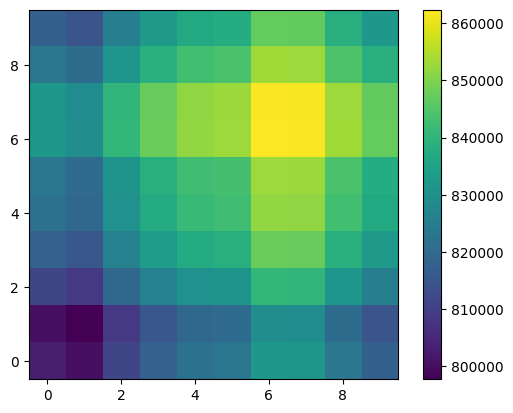

In [63]:
two_time = scattering.two_time_correlation(I0_batch,1,168) 
plt.imshow(two_time.cpu(), origin='lower')
cbar = plt.colorbar()
plt.show()
#makes sense? Most of the action happens in the first few frames

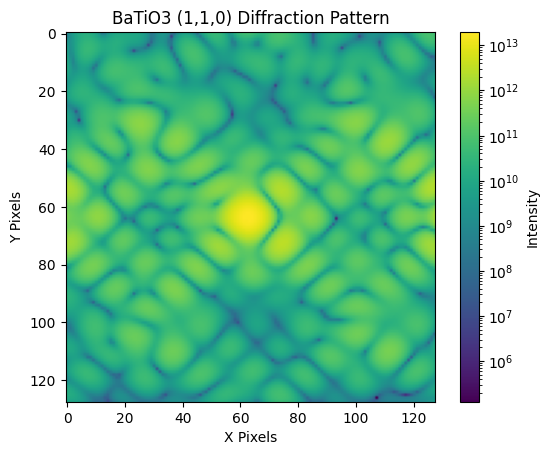

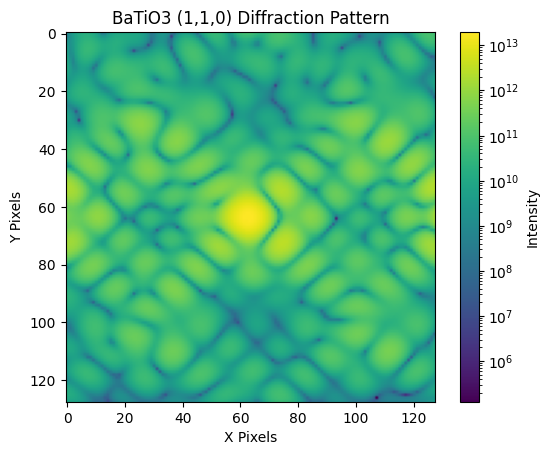

In [35]:
#vmax = 1e16,vmin = 1e10
plt.imshow(I0[0,...].cpu(),norm=colors.LogNorm())
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.title("BaTiO3 (1,1,0) Diffraction Pattern")
cbar = plt.colorbar()
cbar.set_label("Intensity")
plt.show()

plt.imshow(I02[0,...].cpu(),norm=colors.LogNorm())
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.title("BaTiO3 (1,1,0) Diffraction Pattern")
cbar = plt.colorbar()
cbar.set_label("Intensity")
plt.show()

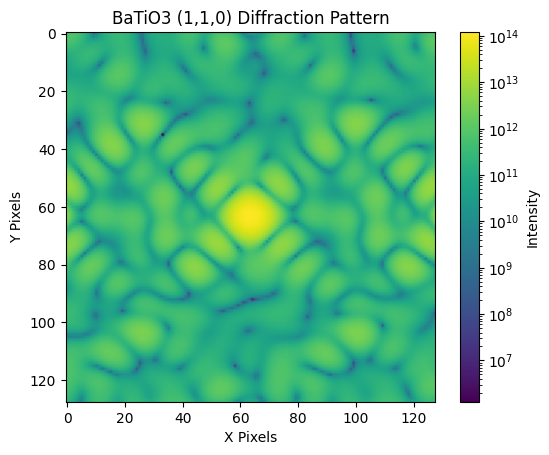

In [14]:
# This animation shows an alternating dislocation that is scaled by cos

t = np.linspace(0,1,100)
w = 2*torch.pi

fig, ax = plt.subplots()
cax = None


im = ax.imshow(I0[0,...].cpu(),norm=colors.LogNorm())
cbar = fig.colorbar(im)
cbar.set_label("Intensity")
ax.set_xlabel("X Pixels")
ax.set_ylabel("Y Pixels")
ax.set_title("BaTiO3 (1,1,0) Diffraction Pattern")
    
def update(frame):
    im.set_data(I0[frame,...].cpu())
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(t), interval=100, blit=False)
ani.save("swarm_diffraction_pattern_50.gif", writer="pillow", fps=10)
#HTML(ani.to_jshtml())

In [158]:
scattering_perf = CoherentScattering(crystal = crystal,
                                K_i = k_i,
                                K_f = k_f,
                                detector = Detector(
                                    X = 128,
                                    Y = 128,
                                    d_xy = 50e-6,
                                    R = R,
                                    #R = 0.3946,
                                    wavelength = wavelength,
                                    dtype=dtype,
                                    device=device
                                ),
                                dtype=dtype,
                                device=device)
inten_perf = scattering_perf.get_intensity(d=(5,5,5)) # n changes the pattern, higher n makes it looks zoomed out  



## XRD

/Users/b330987/miniconda3/envs/torch27/lib/python3.13/site-packages/pymatgen/analysis/diffraction/core.py:169: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.get_plot(structure, **kwargs).get_figure().show()


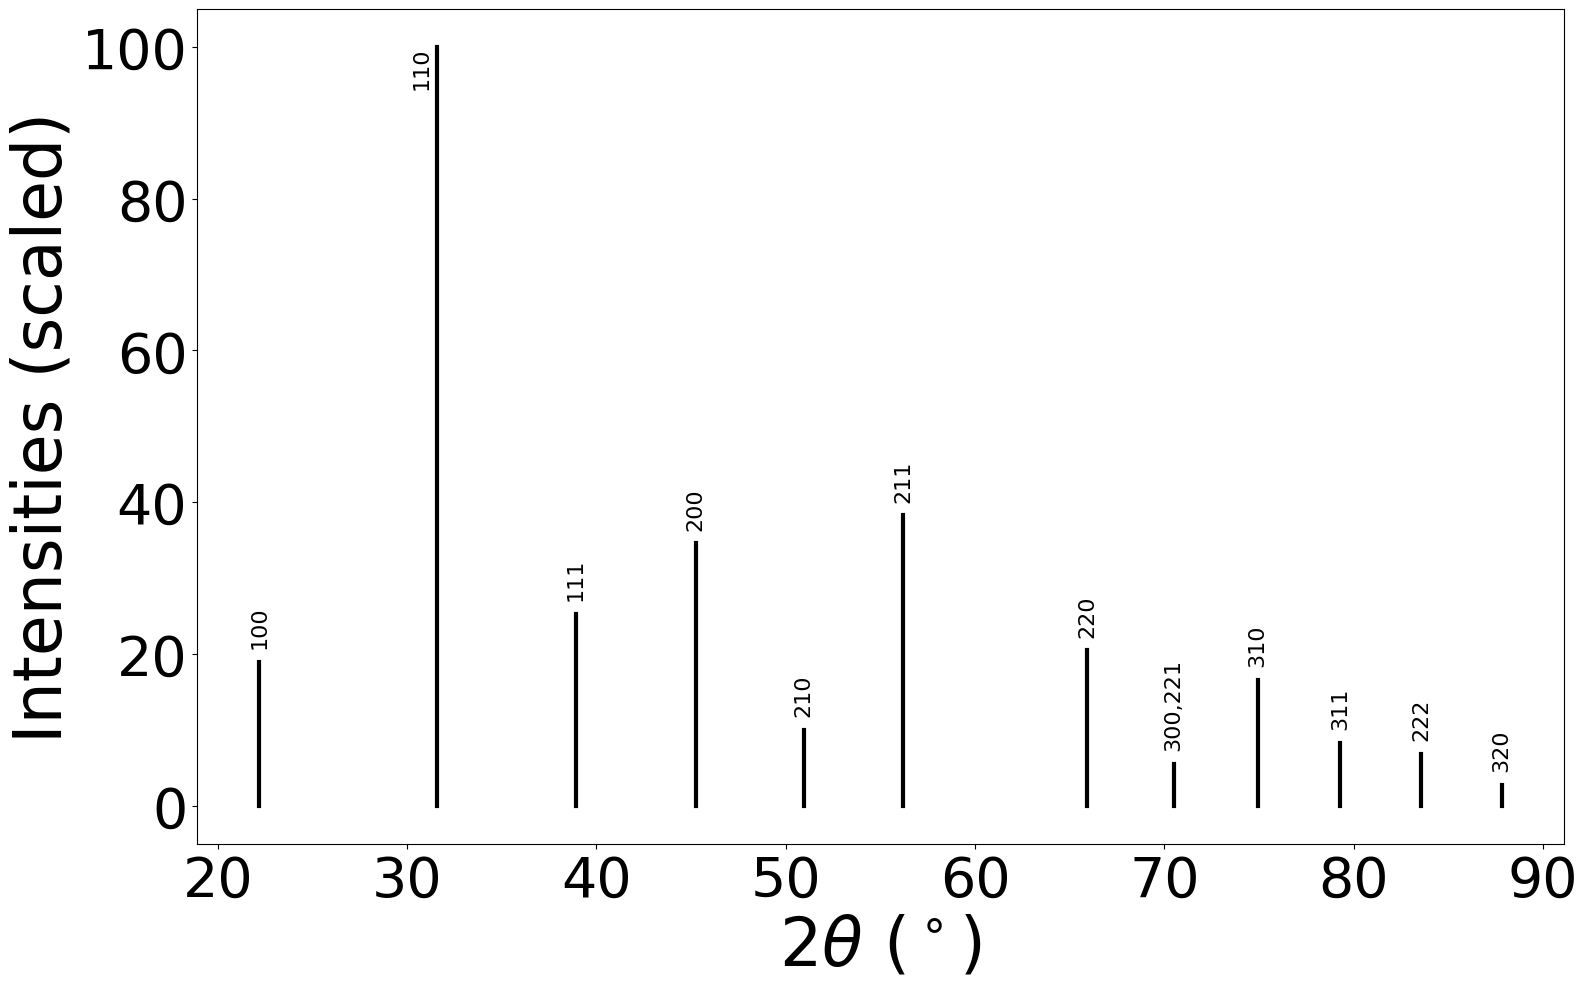

In [95]:
pattern, val = crystal.get_XRD(structure)
plt.show()

In [96]:
val

DiffractionPattern
$2\Theta$: [22.18115524 31.57126512 38.92360025 45.25286344 50.95179281 56.22252752
 65.92334706 70.49110061 74.93301873 79.28389038 83.57297284 87.82610626]
Intensity: [ 19.00223951 100.          25.22224056  34.56596701   9.96203567
  38.2594319   20.46656905   5.46194633  16.59332756   8.32831977
   6.81877802   2.74262471]

## Plotting Intensities

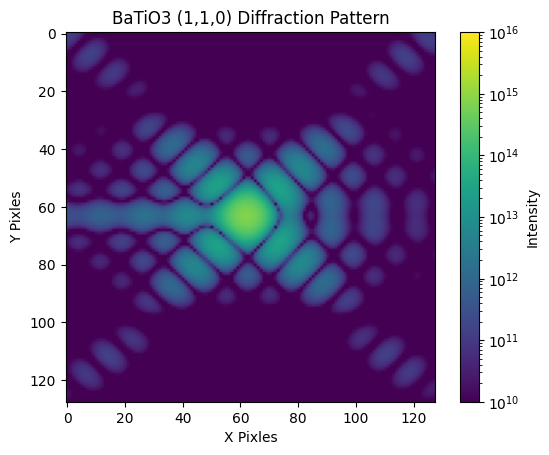

In [19]:
## Should prob experiment with adding Possion or Gaussian noise

#(could also be fun to see if neural net could work with noisier and noiser perfect diffraction data)
#vmax = Detector.round_in_base(inten.max().item(), digits = 1)
#vmin = vmax/1e5
t = torch.linspace(0,1,50)
I0 = scattering.get_intensity(d=(5,5,5), option = 'scale_displacement', t = t[-1], w = 2*torch.pi, scale = .05 * crystal.lattice_vectors.norm())
plt.imshow(I0.cpu(),norm=colors.LogNorm(vmax = 1e16,vmin = 1e10))
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.title("BaTiO3 (1,1,0) Diffraction Pattern")
cbar = plt.colorbar()
cbar.set_label("Intensity")
plt.show()

## Acts as I expect it to when disclocations are very small, but as they get larger the pattern essentially just gets more grainy, that's it
# and not significantly more grainy as it gets unreasonably large

In [96]:



n_grains = 200
axes = ['x', 'y', 'z']

sizes = [(i, i, i) for i in 10 * np.random.randint(1, 6, size=n_grains)]
axis = np.random.randint(len(axes), size=n_grains)
angle = 2 * np.random.randn(n_grains)
crystal_misorientations = [(i, axes[j]) for (i,j) in zip(angle, axis)]


polycrystal = Polycrystal(
    'BaTiO3.cif',
    bounding_box = (1e-6, 1e-6, 1e-6),
    crystal_sizes = sizes,
    crystal_misorientations = crystal_misorientations,
    miller_indices = (1,1,0),
    target_axis = 'x',
    dtype = dtype,
    device = device
)


In [97]:
l = []
for i in sizes[0]:
    d = np.random.randint(2,6)
    while i % d != 0:
        d = np.random.randint(2,6)
    l.append(d)
d = tuple(l)
tup = tuple(l)
print(tup)

(2, 2, 5)


In [100]:
total_amp = 0




for grain in polycrystal.grains:
    scattering = CoherentScattering(
        crystal=grain,
        K_i=k_i,
        K_f=k_f,
        detector=Detector(
            X=128,
            Y=128,
            d_xy=50e-6,
            R=R,
            wavelength=wavelength,
            dtype=dtype,
            device=device
        ),
        dtype=dtype,
        device=device
    )
    r_out = np.random.randint(10,65)

    size = sizes[polycrystal.grains.index(grain)]
    size_l = []
    for i in size:
        d = np.random.randint(2,6)
        while i % d != 0:
            d = np.random.randint(2,6)
        size_l.append(d)
    d = tuple(size_l)
    
        
    amp = scattering.get_amplitude(d=(4,4,4), shape_mask=None, r_out=r_out, start_coord=(0,0,0), end_coord=(2e-8,2e-8,2e-8))  # amplitude

    total_amp += amp

inten_total = (total_amp.abs() ** 2)


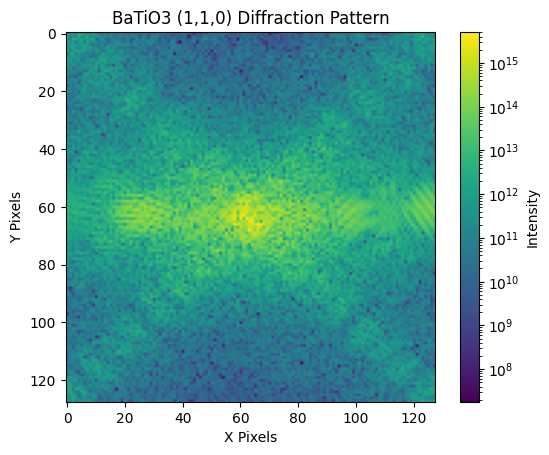

In [101]:
plt.imshow(inten_total.cpu(),norm=colors.LogNorm())
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.title("BaTiO3 (1,1,0) Diffraction Pattern")
cbar = plt.colorbar()
cbar.set_label("Intensity")
plt.show()

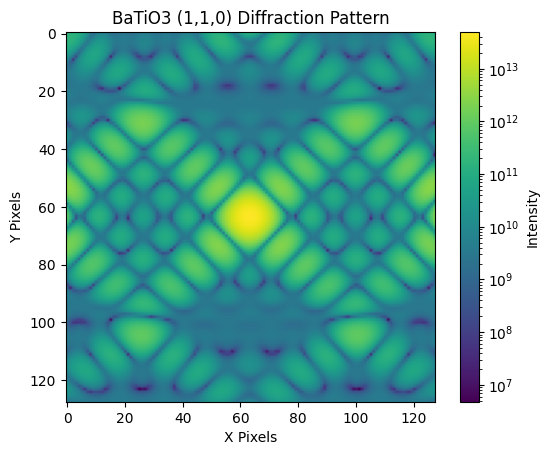

In [66]:

scattering_perf_rad = CoherentScattering(crystal = crystal,
                                K_i = k_i,
                                K_f = k_f,
                                detector = Detector(
                                    X = 128,
                                    Y = 128,
                                    d_xy = 50e-6,
                                    R = R,
                                    #R = 0.3946,
                                    wavelength = wavelength,
                                    dtype=dtype,
                                    device=device
                                ),
                                dtype=dtype,
                                device=device)
inten_perf = scattering_perf_rad.get_intensity(d=(10,10,10), shape_mask = 'circle', r_out = 60,)
inten_perf = inten_perf[:,:]
plt.imshow(inten_perf.cpu(),norm=colors.LogNorm())
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.title("BaTiO3 (1,1,0) Diffraction Pattern")
cbar = plt.colorbar()
cbar.set_label("Intensity")
plt.show()

## Noise

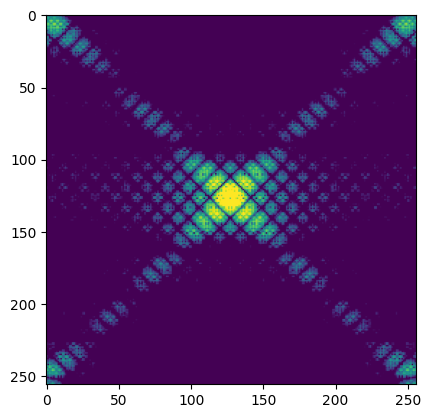

In [95]:
gaussian_noise = np.random.normal(1e-4, 1e-4, inten.shape)
plt.imshow(inten.cpu()+torch.from_numpy(gaussian_noise), norm=colors.LogNorm(vmin = 1e+11, vmax = 1e+15))

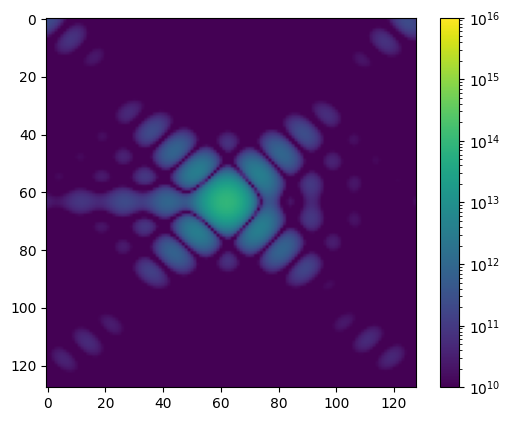

In [108]:
poisson_noise = torch.poisson(inten.cpu())
noisy_pattern = inten.cpu() + poisson_noise
plt.imshow(noisy_pattern, norm=colors.LogNorm(vmax = 1e16,vmin = 1e10)) ## trying to change plotting
plt.colorbar()
plt.show()

# Max Intensity Test

In [13]:
I_max = scattering.max_intensity(rotated_structure = rotated_structure) ## I have no clue how to plot this

In [14]:
I_max.shape

torch.Size([256, 256])

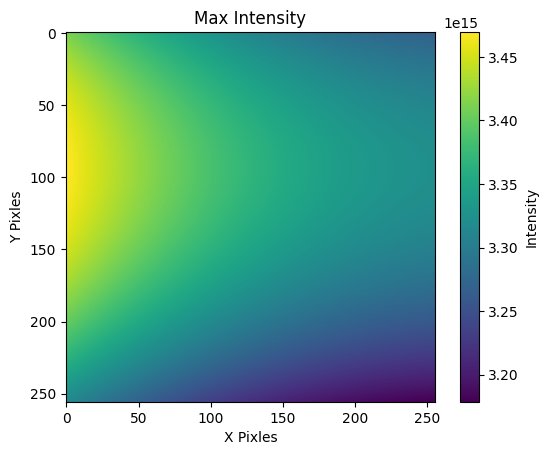

In [15]:
plt.imshow(I_max.cpu()) ## trying to change plotting
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.title("Max Intensity")
cbar = plt.colorbar()
cbar.set_label("Intensity")
plt.show()

# $$Na(BH)_5$$

In [54]:
crystal_NaBH = Crystal(
    'Na(BH)5.cif',
    crystal_size = (100, 100, 100),
    dtype = dtype,
    device = device
)
 
structure_NaBH = crystal_NaBH.parse_cif_file()
rotated_structure_NaBH = crystal_NaBH.align_miller_plane_to_axis(structure_NaBH, (0,2,1), target_axis='x')
crystal_NaBH.calculate_crystal_properties(rotated_structure_NaBH)
crystal_NaBH.get_atomic_form_factors()
lengths_Na = crystal_NaBH.lattice_vectors.norm(dim=1)
print('Sample size:', ' nm x '.join('{:.1f}'.format(crystal_NaBH.crystal_size[i] * lengths_Na[i] * 1e9) for i in range(len(lengths_Na))), 'nm')

Sample size: 67.4 nm x 133.4 nm x 122.7 nm


In [55]:
wavelength = 1.5406e-10 #m

R_Na = get_R(crystal = crystal_NaBH, beta = 5, rotated_structure = rotated_structure_NaBH, wavelength = wavelength, d_xy = 50e-6)
print(R_Na)

0.21885749058808246


In [56]:
theta_B = torch.deg2rad(torch.torch.tensor(7.834377355, dtype=dtype, device = device)) 
k_i = torch.tensor([torch.sin(-theta_B), 0.0, torch.cos(-theta_B)], dtype=dtype, device=device)
k_f = torch.tensor([torch.sin(theta_B), 0., torch.cos(theta_B)], dtype=dtype, device=device)
scattering_NaBH = CoherentScattering(crystal = crystal_NaBH,
                                K_i = k_i,
                                K_f = k_f,
                                detector = Detector(
                                    X = 256,
                                    Y = 256,
                                    d_xy = 50e-6,
                                    R = R_Na,
                                    #R = 0.3946,
                                    wavelength = wavelength,
                                    dtype=dtype,
                                    device=device
                                ),
                                dtype=dtype,
                                device=device)
t0 = time.time()
inten_Na = scattering_NaBH.get_intensity(d=(6,6,6)) # n changes the pattern, higher n makes it looks zoomed out  
print(time.time() - t0)


0.9419939517974854


/Users/b330987/miniconda3/envs/torch27/lib/python3.13/site-packages/pymatgen/analysis/diffraction/core.py:169: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.get_plot(structure, **kwargs).get_figure().show()


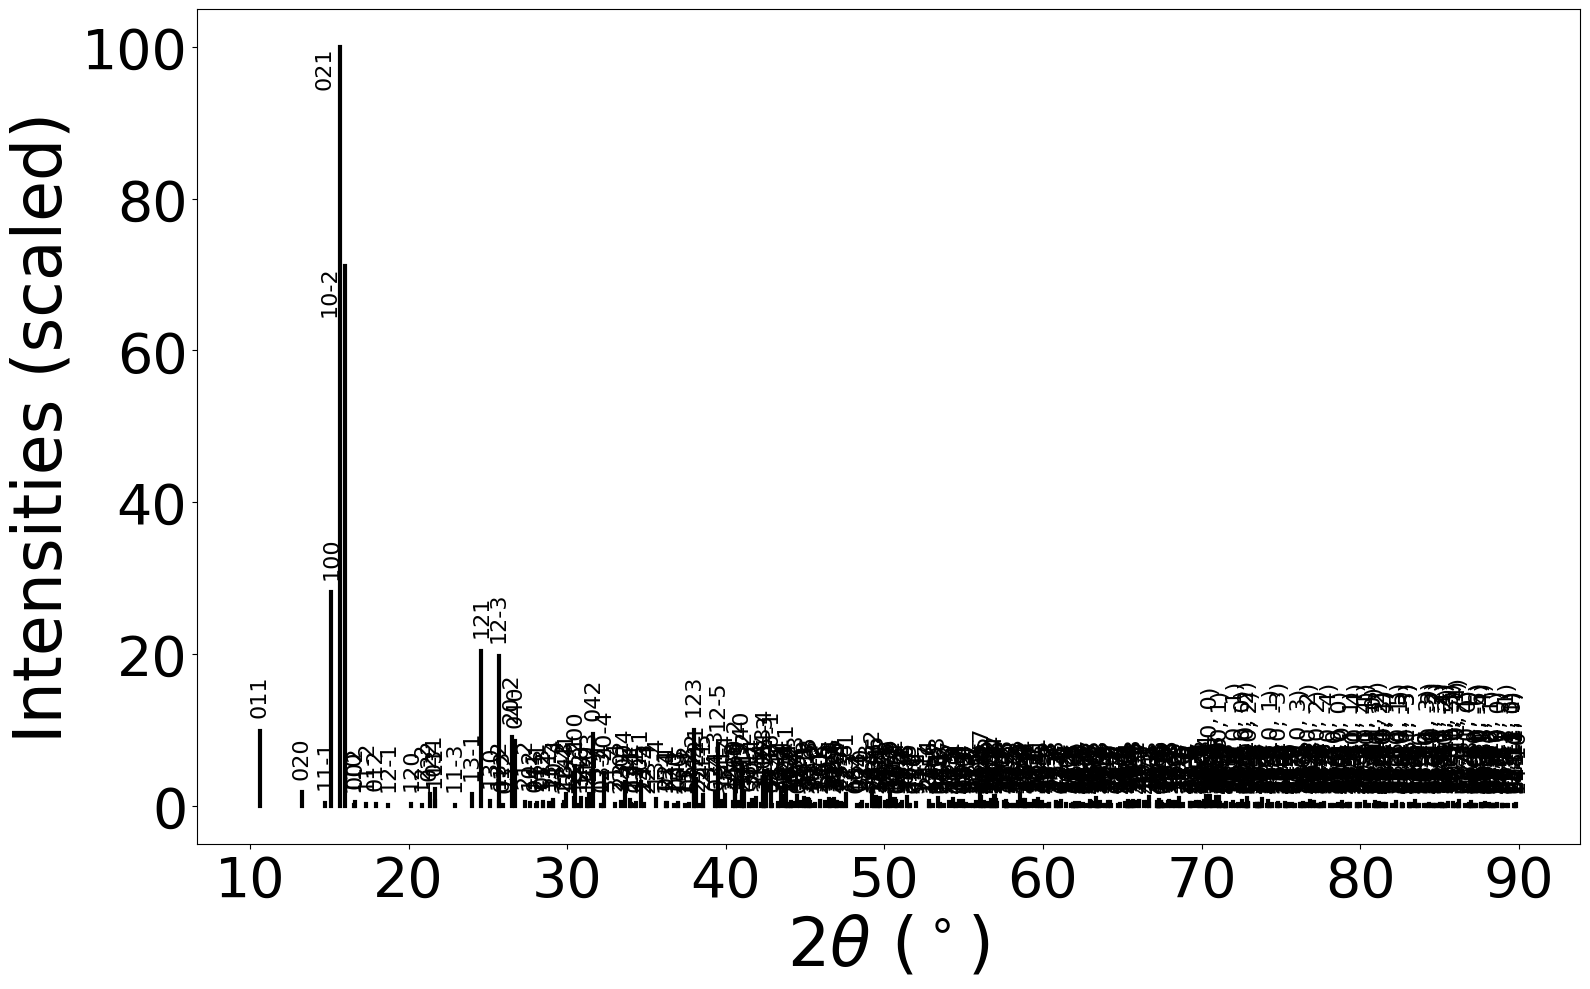

In [41]:
pattern, val = crystal_NaBH.get_XRD(structure_Na)
plt.show()

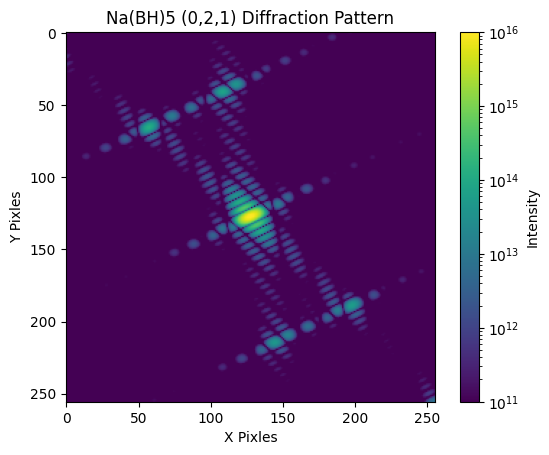

In [57]:
plt.imshow(inten_Na.cpu(),norm=colors.LogNorm(vmin = 1e+11, vmax = 1e+16)) #not sure for the norm
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.title("Na(BH)5 (0,2,1) Diffraction Pattern")
cbar = plt.colorbar()
cbar.set_label("Intensity")
plt.show()

In [97]:
crystal.atom_positions[:,2].shape

torch.Size([88])

# Timing Plots

Calculating error wrt the smallest possible unit cell and overlay it wrt time
Using equation 15 of the paper -- > I0 is the smallest unit cell size (start with 50)

import gc
del ...
torch.cuda.empty_cache()
gc.collect()

In [12]:
def chi_sqr_err(I0,Id):
    sqr_diff = (torch.sqrt(Id)-torch.sqrt(I0))**2
    return torch.sum(sqr_diff) / torch.sum(I0)
  

## 50

In [37]:
inten_perf_0 = scattering_perf.get_intensity(d=(2,2,2))
t0 = time.time()
for i in range(100):
    inten = scattering_perf.get_intensity(d=(2,2,2)) # n changes the pattern, higher n makes it looks zoomed out  
print((time.time() - t0)/100)


0.035199427604675294


In [88]:
inten_perf_500_2 = scattering_perf.get_intensity(d=(10,10,5))
t0 = time.time()
for i in range(100):
    inten = scattering_perf.get_intensity(d=(10,10,2)) # n changes the pattern, higher n makes it looks zoomed out  
print((time.time() - t0)/100)


0.0029931211471557616


In [89]:
Supercell_volume_list_50 = np.array([8, 20, 50, 125, 40, 200, 100, 250, 500, 1000])
err_20_2 = chi_sqr_err(inten_perf_0,inten_perf_20_2)
err_50_2 = chi_sqr_err(inten_perf_0,inten_perf_50_2)
err_125 = chi_sqr_err(inten_perf_0,inten_perf_125)
err_40_2 = chi_sqr_err(inten_perf_0,inten_perf_40_2)
err_200_2 = chi_sqr_err(inten_perf_0,inten_perf_200_2)
err_100_2 = chi_sqr_err(inten_perf_0,inten_perf_100_2)
err_250_2 = chi_sqr_err(inten_perf_0,inten_perf_250_2)
err_500_2 = chi_sqr_err(inten_perf_0,inten_perf_500_2)
err_1000 = chi_sqr_err(inten_perf_0,inten_perf_1000)

In [97]:
#err_perf_list = [0, err_20.cpu(), err_50.cpu(), err_125.cpu(), err_40.cpu(), err_200.cpu(), err_100.cpu(), err_250.cpu(), err_500.cpu(), err_1000.cpu()]
err_perf_list_2 = [0, err_20_2.cpu(), err_50_2.cpu(), err_125.cpu(), err_40_2.cpu(), err_200_2.cpu(), err_100_2.cpu(), err_250_2.cpu(), err_500_2.cpu(), err_1000.cpu()]
print(err_perf_list_2)
print(err_perf_list)

[0, tensor(0.0009), tensor(0.0019), tensor(0.0021), tensor(0.0561), tensor(0.2075), tensor(0.0620), tensor(0.0634), tensor(0.2107), tensor(0.2236)]
[0, tensor(8.7049e-07), tensor(0.0010), tensor(0.0021), tensor(1.9817e-05), tensor(0.0632), tensor(0.0013), tensor(0.0028), tensor(0.0697), tensor(0.2236)]


In [124]:
time_perf_list = [0.0351994276, 0.01431217909, 0.006630198956, 0.003051257133, 0.007970559597, 0.002872152328, 0.004013369083, 0.002081637383, 0.001953589916, 0.001931278706]
x_fit_50 = np.linspace(min(Supercell_volume_list_50), 250, 500)
x_fit_err =  np.linspace(min(Supercell_volume_list_50), max(Supercell_volume_list_50), 500)

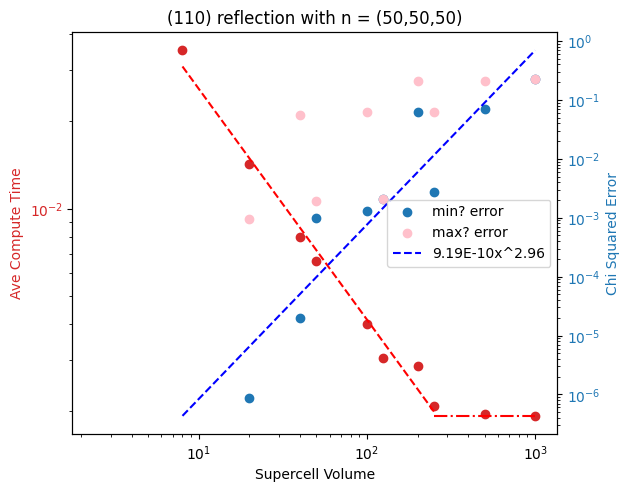

In [138]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel('Supercell Volume')
ax1.set_ylabel('Ave Compute Time', color=color)
ax1.scatter(Supercell_volume_list_50, time_perf_list, color=color)
ax1.plot(x_fit_50,0.162*x_fit_50**-0.796, 'r--', label = '0.162x^-0.796')
ax1.tick_params(axis='y', labelcolor=color)
ax1.hlines(y=0.00193, xmin=250, xmax = 1000, color = 'red', ls = "-.")
#ax1.axhline(y=0.00193, xmin = 250, xmax = 1000, label = 'y=0.00193', color = 'red')
#ax1.axvline(x=40, label = '(110) reflection d = (2,2,10)', color = 'green')
#ax1.axvline(x=250, label = '(110) reflection d = (5,5,10)', color = 'purple')


ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.set_xscale("log")
ax2.set_yscale("log")
color = 'tab:blue'
ax2.set_ylabel('Chi Squared Error', color=color)  # we already handled the x-label with ax1
ax2.scatter(Supercell_volume_list_50, err_perf_list, color=color, label = 'min? error')
ax2.scatter(Supercell_volume_list_50, err_perf_list_2, color='pink',label = 'max? error')
ax2.plot(x_fit_err,9.19E-10*x_fit_err**2.96, 'b--', label = '9.19E-10x^2.96')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc = 'center right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('(110) reflection with n = (50,50,50)')
plt.show()

## 60

In [160]:
'''
inten_60perf_10 = scattering_perf.get_intensity(d=(10,10,10))
t0 = time.time()
for i in range(100):
    inten = scattering_perf.get_intensity(d=(10,10,10)) # n changes the pattern, higher n makes it looks zoomed out  
t10 = (time.time() - t0)/100
print((time.time() - t0)/100)
er10 = chi_sqr_err(inten_60perf_0,inten_60perf_10)
'''

0.002805328369140625


In [7]:
Supercell_volume_list_60_perf = np.array([2**3, 3**3, 4**3, 5**3 ,6**3, 10**3, 12**3, 15**3, 20**3, 30**3])
t_list = [0.08161668777, 0.02741724968, 0.008424868584, 0.004960010052, 0.003178958893, 0.002805328369, 0.002121510506, 0.001984069347, 0.001954548359, 0.001470067501]
err_l = [1e-10, 1.9975e-05, 0.0001, 0.0006, 0.0023, 0.1272, 0.2141, 2.4752, 4.1685, 17.6388]


x_fit = np.linspace(min(Supercell_volume_list_60_perf), max(Supercell_volume_list_60_perf), 300)

Supercell_volume_list_60_dis = np.array([3**3, 4**3, 5**3 ,6**3, 10**3, 12**3, 15**3, 20**3, 30**3])
time_list_60 = np.array([0.133293199539184, 0.0568516969680786, 0.0330431938171386, 0.0278009176254272, 0.00902431011199951, 0.00835411548614501, 0.00820999145507812, 0.00809931755065918, 0.00794649124145507])

In [8]:
def power_law(V, a, b):
    return a * V**b

popt, pcov = curve_fit(power_law, Supercell_volume_list_60_perf, t_list)
a_fit, b_fit = popt
print(a_fit,b_fit)


popter, pcover = curve_fit(power_law, Supercell_volume_list_60_perf, err_l)
a_er, b_er = popter
print(a_er, b_er)

popt_dis, pcov_dis = curve_fit(power_law, Supercell_volume_list_60_dis, time_list_60)
a_dis, b_dis = popt_dis


def power_law_offset(V, a, b, c):
    return a * V**(-b) + c



0.6043252660822276 -0.9614630505906836
0.00015584793402168026 1.1403868706809095


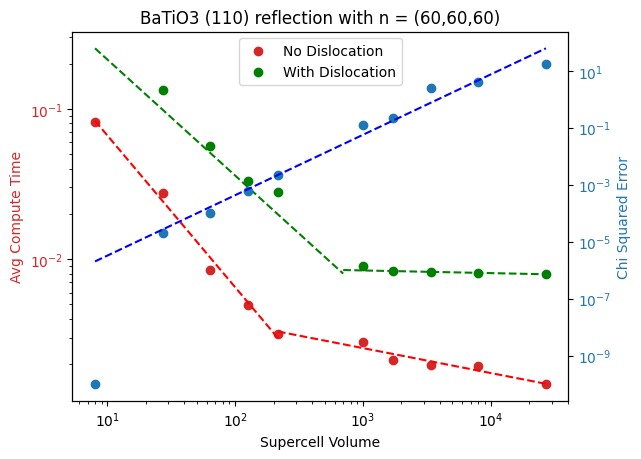

In [9]:
#popt, pcov = curve_fit(power_law, Supercell_volume_list_60_perf, t_list)
#a_fit, b_fit, c_fit = popt

#popt1, pcov1 = curve_fit(power_law, Supercell_volume_list_60_dis, time_list_60)
#a_fit1, b_fit1, c_fit1 = popt1
x_fit_1 = np.linspace(min(Supercell_volume_list_60_perf), 216, 300)
x_fit_2 = np.linspace(216, max(Supercell_volume_list_60_perf), 300)

x_fit_1_1 = np.linspace(min(Supercell_volume_list_60_perf), 700, 300)
x_fit_2_1 = np.linspace(700, max(Supercell_volume_list_60_perf), 300)

fig2, ax3 = plt.subplots()

color = 'tab:red'

ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel('Supercell Volume')
ax3.set_ylabel('Avg Compute Time', color=color)
ax3.scatter(Supercell_volume_list_60_perf, t_list, color=color, label = 'No Dislocation')
#ax3.plot(x_fit,power_law(x_fit, a_fit, b_fit), 'r--', label = '')
ax3.plot(x_fit_1,0.681*x_fit_1**-1.01, 'r--', label = '') #0.681x^-1.01
ax3.plot(x_fit_2,8.06E-03*x_fit_2**-0.166, 'r--', label = '') #8.06E-03x^-0.166
ax3.tick_params(axis='y', labelcolor=color)
#ax3.hlines(y=0.00193, xmin=250, xmax = 1000, color = 'red', ls = "-.")
ax3.scatter(Supercell_volume_list_60_dis, time_list_60, color = 'green', label = 'With Dislocation') 
ax3.plot(x_fit_1_1,1.26*x_fit_1_1**-0.772, 'g--', label = '') #1.26x^-0.722
ax3.plot(x_fit_2_1,9.51E-03*x_fit_2_1**-0.0177, 'g--', label = '') #9.51E-03x^-0.0177



ax4 = ax3.twinx()  # instantiate a second Axes that shares the same x-axis
ax4.set_xscale("log")
ax4.set_yscale("log")
color = 'tab:blue'
ax4.set_ylabel('Chi Squared Error', color=color)  
ax4.scatter(Supercell_volume_list_60_perf, err_l, color=color)
#ax4.plot(x_fit,a_er*x_fit**(b_er), 'b--', label = '') #2.5E-08x^2.12
ax4.plot(x_fit,2.5e-08*x_fit**2.12, 'b--', label = "2.5e-08*x_fit**2.12") #I guessed the fitting funtion -- I'm very proud of that
ax4.tick_params(axis='y', labelcolor=color)
ax3.legend(loc = 'upper center')

#fig2.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('BaTiO3 (110) reflection with n = (60,60,60)')
plt.savefig("Timing_plot.jpg", dpi = 300) 
plt.show()

In [12]:
# Run it for 80x80x80... overlay compute size 
# Either alternaring displacement, or seeded randim dsplacement (torch.manual_seed(3))

## 80

In [71]:
'''
scale = .05 * crystal.lattice_vectors.norm()
inten_80_512000 = scattering.get_intensity(d=(10,10,10), scale = scale)
t0 = time.time()
for i in range(100):
    inten = scattering.get_intensity(d=(10,10,10), scale = scale) # n changes the pattern, higher n makes it looks zoomed out  
t10 = (time.time() - t0)/100
print((time.time() - t0)/100)
er512000 = chi_sqr_err(inten_80_64,inten_80_512000)
print(er512000)
'''

0.04892925977706909
tensor(0.1134, device='mps:0')


In [29]:
sup_size = [8,64,125,512,1000,4096,8000,64000, 80**3]
t_80 = [0.141294150352478, 0.0184526896476745, 0.00988025188446044, 0.00355675220489501, 0.0029240703582763673, 
        0.0020760393142700197, 0.001906599998474121, 0.0011515069007873536, 0.0010916590690612793]
er_80 = [1e-10, 3.61e-5, 0.0001, 0.0025, 0.1160, 0.2053, 2.5194, 17.7429, 167.9222]
sup_err = [64,125,512,1000,4096,8000,64000, 80**3]
t_disloc = [0.1784894895553589, 0.11032127857208252, 0.05160271883010864, 0.04411409139633179, 0.0353781008720398, 0.035097191333770754,
           0.03446579933166504, 0.03274874210357666]
er_disloc = [1e-10, 4.8404e-05, 0.0023, 0.1134, 0.2186, 2.4922, 18.5461,188.0996]


In [30]:
popt_80_er, pcov_80_er= curve_fit(power_law, sup_size, er_80)
a_80_er, b_80_er = popt_80_er



popt_80_t, pcov_80_t = curve_fit(power_law,sup_size,t_80, p0 = [0.0808, -0.452])
a_80_t, b_80_t = popter
print(popter)




[1.55847934e-04 1.14038687e+00]


In [31]:
popt2, pcov2 = curve_fit(power_law, sup_size, t_80)
a_fit2, b_fit2= popt2



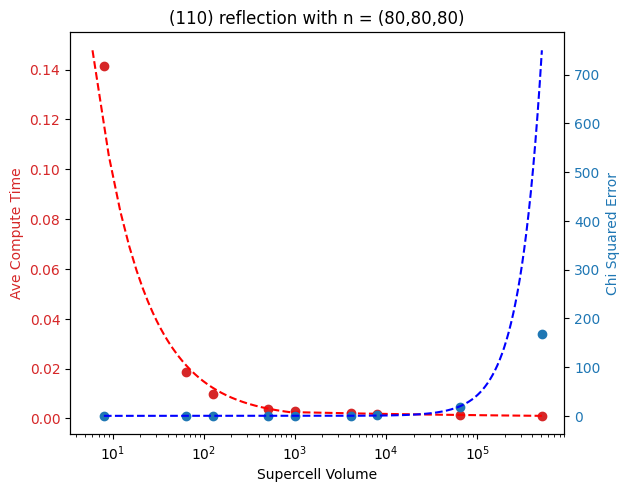

In [73]:
fig, ax1 = plt.subplots()

x_fit_80_1 = np.linspace(6, 920, 300)
x_fit_80_2 = np.linspace(920, max(sup_size), 300)

color = 'tab:red'

ax1.set_xscale("log")
#ax1.set_yscale("log")
ax1.set_xlabel('Supercell Volume')
ax1.set_ylabel('Ave Compute Time', color=color)
ax1.scatter(sup_size, t_80, color=color, label = 'Time No Dislocation')
#ax1.scatter(sup_err, t_disloc, color = 'orange', label = 'Time Dislocation')
ax1.plot(x_fit_80_1,0.641*x_fit_80_1**-0.819, 'r--', label = '')  #0.641x^-0.819
ax1.plot(x_fit_80_2,6.67E-03*x_fit_80_2**-0.144, 'r--', label = '')  #6.67E-03x^-0.144
ax1.tick_params(axis='y', labelcolor=color)
#ax3.hlines(y=0.00193, xmin=250, xmax = 1000, color = 'red', ls = "-.")
#ax1.scatter(Supercell_volume_list_60_perf, time_list_60, color = 'green', label = 'With Dislocation')



ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.set_xscale("log")
#ax2.set_yscale("log")
color = 'tab:blue'
ax2.set_ylabel('Chi Squared Error', color=color)  
ax2.scatter(sup_size, er_80, color=color, label = 'Error No Dislocation')
#ax2.scatter(sup_err, er_disloc, color = 'purple', label = 'Error Dislocation')
#ax2.plot(x_fit_80,a_80_er*x_fit_80**(b_80_er), 'b--', label = '')
ax2.plot(x_fit_80,6.71e-08*x_fit_80**(1.76), 'b--', label = '') #6.71E-08x^1.76
ax2.tick_params(axis='y', labelcolor=color)
#ax1.legend(loc = 'center right')
#ax2.legend(loc = 'center right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('(110) reflection with n = (80,80,80)')
plt.show()

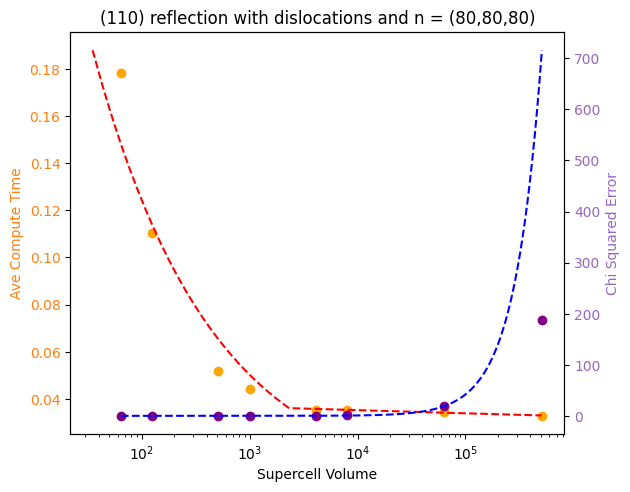

In [86]:
x_fit_80_1 = np.linspace(35, 2400, 300)
x_fit_80_2 = np.linspace(2500, max(sup_err), 300)
x_fit_80_11 = np.linspace(min(sup_err), max(sup_err), 300)

fig, ax1 = plt.subplots()

color = 'tab:orange'

ax1.set_xscale("log")
#ax1.set_yscale("log")
ax1.set_xlabel('Supercell Volume')
ax1.set_ylabel('Ave Compute Time', color=color)
ax1.scatter(sup_err, t_disloc, color = 'orange', label = 'Time Dislocation')
ax1.plot(x_fit_80_1,0.763*x_fit_80_1**-0.394, 'r--', label = '') #0.763x^-0.394
ax1.plot(x_fit_80_2,0.041*x_fit_80_2**-0.0167, 'r--', label = '') #0.041x^-0.0167
ax1.tick_params(axis='y', labelcolor=color)


#pop, cov= curve_fit(power_law_offset, sup_err, er_disloc)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.set_xscale("log")
#ax2.set_yscale("log")
color = 'tab:purple'
ax2.set_ylabel('Chi Squared Error', color=color)  
ax2.scatter(sup_err, er_disloc, color = 'purple', label = 'Error Dislocation')
ax2.plot(x_fit_80_11,8.33E-08*x_fit_80_11**1.74, 'b--', label = "2.5e-08*x_fit**2.12") #8.33E-08x^1.74

ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('(110) reflection with dislocations and n = (80,80,80)')
plt.show()

In [33]:


n1,n2,n3 = (10,10,10)
d1,d2,d3 = (2,2,2)

i_indices = torch.arange(0, n1, d1, dtype=dtype, device=device)
j_indices = torch.arange(0, n2, d2, dtype=dtype, device=device)
k_indices = torch.arange(0, n3, d3, dtype=dtype, device=device)

            # Compute a grid of all indices

i, j, k = torch.meshgrid(i_indices, j_indices, k_indices, indexing='xy')
 
            # Reshape to [n_supercells, 3]

supercell_indices = torch.stack([i.flatten(), j.flatten(), k.flatten()], dim=1)

            # Calculate positions in real space --> this is R_nd

        #This is our R_nd comp
print(supercell_indices.shape)

#supercell_positions = torch.matmul(supercell_indices, self.crystal.lattice_vectors) ## full grid of R_nd

center_i = (n1 - 1) / 2
center_j = (n2 - 1) / 2
center_k = (n3 - 1) / 2

            # Downsampled center
center_i /= d1
center_j /= d2
center_k /= d3


            # Compute distance from center for each grid point
dist_from_center = torch.sqrt((i - center_i) ** 2 + (j - center_j) ** 2 + (k - center_k) ** 2)

            

mask = (dist_from_center < 10).to(dtype=dtype)  # [n1, n2, n3]
mask = mask.flatten()  # [n1, n2, n3, 1]
print(mask.shape)

        
#supercell_positions = supercell_positions * mask  # [n1, n2, n3, 3]
            

torch.Size([125, 3])
torch.Size([125])


In [127]:
d1, d2, d3 = (5,5,5)
n1, n2, n3 = (50, 50, 50)

i_indices = torch.arange(0, n1, d1, dtype=dtype, device=device)
j_indices = torch.arange(0, n2, d2, dtype=dtype, device=device)
k_indices = torch.arange(0, n3, d3, dtype=dtype, device=device)

            # Compute a grid of all indices

i, j, k = torch.meshgrid(i_indices, j_indices, k_indices, indexing='xy')
 
            # Reshape to [n_supercells, 3]

supercell_indices = torch.stack([i.flatten(), j.flatten(), k.flatten()], dim=1)

            # Calculate positions in real space --> this is R_nd

supercell_positions = torch.matmul(supercell_indices, crystal.lattice_vectors) ## full grid of R_nd

print(supercell_indices)
'''
x0, y0, z0 = start_coord
x1, y1, z1 = end_coord

mask_bool = (
    (supercell_positions[:, 0] >= x0) & (supercell_positions[:, 0] < x1) &
    (supercell_positions[:, 1] >= y0) & (supercell_positions[:, 1] < y1) &
    (supercell_positions[:, 2] >= z0) & (supercell_positions[:, 2] < z1)
)
'''

tensor([[ 0.,  0.,  0.],
        [ 0.,  0.,  5.],
        [ 0.,  0., 10.],
        ...,
        [45., 45., 35.],
        [45., 45., 40.],
        [45., 45., 45.]], device='cuda:3')


'\nx0, y0, z0 = start_coord\nx1, y1, z1 = end_coord\n\nmask_bool = (\n    (supercell_positions[:, 0] >= x0) & (supercell_positions[:, 0] < x1) &\n    (supercell_positions[:, 1] >= y0) & (supercell_positions[:, 1] < y1) &\n    (supercell_positions[:, 2] >= z0) & (supercell_positions[:, 2] < z1)\n)\n'

In [134]:
supercell_indices.shape

torch.Size([1000, 3])